This program is uses a Generative Adversial Network (GAN) to enhance the resolution of images. \
Here colored images.\
Source:\
https://arxiv.org/pdf/1609.04802.pdf - Paper\
https://www.youtube.com/watch?v=nbRkLE2fiVI - Paper's explanation\
https://www.youtube.com/watch?v=1HqjPqNglPc&t=2s - Code Explanation
 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
def res_block(ip):

    # Function for resudial blocks used and described by the paper at page 5
    # This block is used to construct the generator
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [3]:
def upscale_block(ip):
    
    # Function that provides the upscaling block after the image has run through the residual block to gain a higher resolution
    # See paper at page 5
    # This block is used to construct the generator

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
def create_gen(gen_ip, num_res_block):

    # An GAN contains a generator and discriminator network.
    # The generator is trained and later used to enhance the quality of the image
    # This is the function that creates the generator 
    # Architecture see paper at page 5

    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)       #<-- last ouput layer that generates the enhanced image

    return Model(inputs=gen_ip, outputs=op)

In [22]:
def discriminator_block(ip, filters, strides=1, bn=True):

    # Architecture see paper at page 5
    # This block is used to construct discriminator
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [23]:
def create_disc(disc_ip):

    # A GAN consists of a generator and discriminator. 
    # The discriminator is used to detect fake images from real images => Helps the generator to increase its accurarcy in enhancing images.
    # This function creates the discriminator 


    df = 64
    
    # Architecture of discriminator as described by paper on page 5
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)  #<-- last layer that returns 0 (fake image) or 1 (real image)

    return Model(disc_ip, validity)

In [6]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

In [7]:
def build_vgg(hr_shape):

    # This function builds the VGG19 to the 10th layer

    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)     #<-- weights are predefined for image optimization
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [8]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):

    # This function creates the GAN by combining the generator and the discriminator

    gen_img = gen_model(lr_ip)      #<-- low resolution image is fed in here
    
    gen_features = vgg(gen_img)     #<-- extracts features from generator fake image
    
    disc_model.trainable = False    #<-- discriminator is not trainable here, since it should declare which image is fake and real
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

In [9]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("image dataset/mirflickr25k/lr_images")[:n]          #<--- loads the first n paths from directory where low resolution images are saved


In [10]:
# Loads low resolution images

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("image dataset/mirflickr25k/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)        #<-- converts BGR color scheme to RGB color scheme
    lr_images.append(img_lr)   

In [11]:
# Loads the first n paths from directory where high resolution images are saved
hr_list = os.listdir("image dataset/mirflickr25k/hr_images")[:n]

In [12]:
# Loads high resolution images

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("image dataset/mirflickr25k/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

In [13]:
# Converts lists into arrays

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

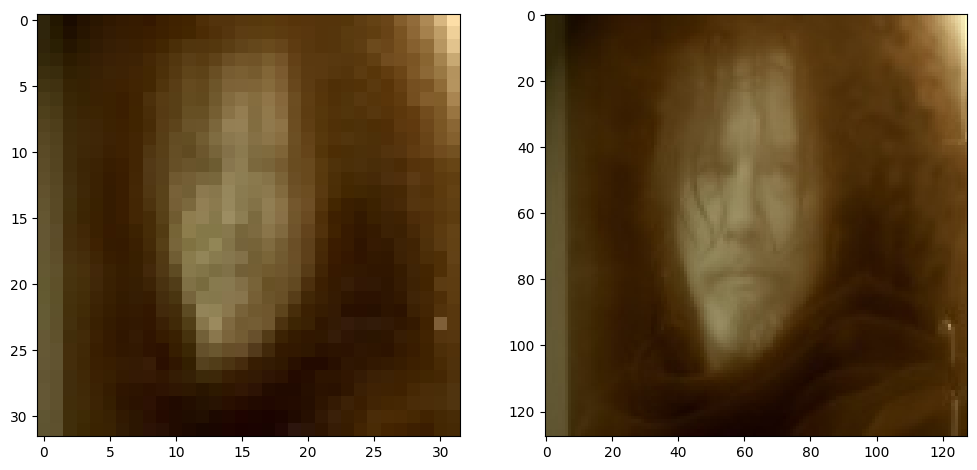

In [14]:
#Sanity check, view few mages - just for testing purposes if loading was correctly 
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [15]:
#Normalize images
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [16]:
# Determine train and test data
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)      #<-- 67% of dataset is used for training, remaining for testing

In [17]:
# Shape of image dataset
np.shape(lr_train)

(3350, 32, 32, 3)

In [18]:
# Gets the shape of low and high resolution images

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [19]:
# Creates input tensor for generator and discriminator

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [20]:
# Creates generator object/ model
generator = create_gen(lr_ip, num_res_block = 16)           #<-- num residual block given by paper
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [24]:
# Creates discriminator object/ model
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])       #<-- binary_crossentropy means that the image is either a true or false image (0,1)
discriminator.summary()                                                                         # it optimizes w.r.t. accuary

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [25]:
# Downloads VGG19 object/ model

# The VGG19 model is used to extract the features of the fake images generated by the generator and compare it to the feature the VGG19
# is able to extract from the original images. The VGG19 is used to compute the loss in features and thus helps to train the generator.
# The VGG19 is able to do that reliable, because it has been trained on million of images before. 

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False               #<-- but sets it as non-trainable

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [26]:
# Creates the GAN object/ model, since generator, discriminator, and VGG19 models are now created

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

In [27]:
#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

# Compiles model, such that it is ready to for the training
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [28]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1                                                  #<-- batch size = 1 means, that 1 image is given to generator and discriminator at once
                                                                # one can increase the number of images supplied to gen and disc, but quality of outcome decreases
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [29]:
#  Trains the GAN

# WARNING!!!!! ONE EPOCH TAKES 14 HOURS TO COMPLETE WITH THIS HARDWARE

epochs = 1                              #<--- vanilla is 5 epochs
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

###################################################################################

  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 1/3350 [00:39<37:00:21, 39.78s/it]

1/1 [==============================] - 0s 155ms/step


  0%|          | 2/3350 [00:45<18:13:30, 19.60s/it]

1/1 [==============================] - 0s 116ms/step


  0%|          | 3/3350 [00:50<11:56:11, 12.84s/it]

1/1 [==============================] - 0s 93ms/step


  0%|          | 4/3350 [00:55<9:02:33,  9.73s/it] 

1/1 [==============================] - 0s 92ms/step


  0%|          | 5/3350 [01:00<7:28:22,  8.04s/it]

1/1 [==============================] - 0s 118ms/step


  0%|          | 6/3350 [01:04<6:26:54,  6.94s/it]

1/1 [==============================] - 0s 105ms/step


  0%|          | 7/3350 [01:09<5:48:28,  6.25s/it]

1/1 [==============================] - 0s 115ms/step


  0%|          | 8/3350 [01:14<5:17:12,  5.70s/it]

1/1 [==============================] - 0s 134ms/step


  0%|          | 9/3350 [01:19<5:03:56,  5.46s/it]

1/1 [==============================] - 0s 108ms/step


  0%|          | 10/3350 [01:23<4:48:25,  5.18s/it]

1/1 [==============================] - 0s 121ms/step


  0%|          | 11/3350 [01:28<4:37:08,  4.98s/it]

1/1 [==============================] - 0s 90ms/step


  0%|          | 12/3350 [01:33<4:33:49,  4.92s/it]

1/1 [==============================] - 0s 93ms/step


  0%|          | 13/3350 [01:37<4:22:37,  4.72s/it]

1/1 [==============================] - 0s 120ms/step


  0%|          | 14/3350 [01:42<4:27:41,  4.81s/it]

1/1 [==============================] - 0s 113ms/step


  0%|          | 15/3350 [01:47<4:26:27,  4.79s/it]

1/1 [==============================] - 0s 122ms/step


  0%|          | 16/3350 [01:52<4:36:01,  4.97s/it]

1/1 [==============================] - 0s 118ms/step


  1%|          | 17/3350 [01:57<4:38:34,  5.01s/it]

1/1 [==============================] - 0s 98ms/step


  1%|          | 18/3350 [02:02<4:29:16,  4.85s/it]

1/1 [==============================] - 0s 95ms/step


  1%|          | 19/3350 [02:06<4:22:17,  4.72s/it]

1/1 [==============================] - 0s 96ms/step


  1%|          | 20/3350 [02:11<4:32:32,  4.91s/it]

1/1 [==============================] - 0s 108ms/step


  1%|          | 21/3350 [02:16<4:34:46,  4.95s/it]

1/1 [==============================] - 0s 90ms/step


  1%|          | 22/3350 [02:21<4:25:01,  4.78s/it]

1/1 [==============================] - 0s 103ms/step


  1%|          | 23/3350 [02:25<4:24:02,  4.76s/it]

1/1 [==============================] - 0s 105ms/step


  1%|          | 24/3350 [02:30<4:25:40,  4.79s/it]

1/1 [==============================] - 0s 117ms/step


  1%|          | 25/3350 [02:35<4:26:22,  4.81s/it]

1/1 [==============================] - 0s 103ms/step


  1%|          | 26/3350 [02:40<4:25:20,  4.79s/it]

1/1 [==============================] - 0s 209ms/step


  1%|          | 27/3350 [02:45<4:36:50,  5.00s/it]

1/1 [==============================] - 0s 126ms/step


  1%|          | 28/3350 [02:50<4:38:38,  5.03s/it]

1/1 [==============================] - 0s 101ms/step


  1%|          | 29/3350 [02:56<4:41:48,  5.09s/it]

1/1 [==============================] - 0s 111ms/step


  1%|          | 30/3350 [03:02<4:55:12,  5.34s/it]

1/1 [==============================] - 0s 123ms/step


  1%|          | 31/3350 [03:09<5:24:54,  5.87s/it]

1/1 [==============================] - 0s 203ms/step


  1%|          | 32/3350 [03:15<5:34:53,  6.06s/it]

1/1 [==============================] - 0s 144ms/step


  1%|          | 33/3350 [03:20<5:18:10,  5.76s/it]

1/1 [==============================] - 0s 124ms/step


  1%|          | 34/3350 [03:26<5:18:15,  5.76s/it]

1/1 [==============================] - 0s 121ms/step


  1%|          | 35/3350 [03:32<5:17:37,  5.75s/it]

1/1 [==============================] - 0s 118ms/step


  1%|          | 36/3350 [03:37<5:08:29,  5.59s/it]

1/1 [==============================] - 0s 129ms/step


  1%|          | 37/3350 [03:43<5:10:55,  5.63s/it]

1/1 [==============================] - 0s 161ms/step


  1%|          | 38/3350 [03:49<5:18:42,  5.77s/it]

1/1 [==============================] - 0s 132ms/step


  1%|          | 39/3350 [03:54<5:16:14,  5.73s/it]

1/1 [==============================] - 0s 131ms/step


  1%|          | 40/3350 [04:00<5:13:26,  5.68s/it]

1/1 [==============================] - 0s 125ms/step


  1%|          | 41/3350 [04:06<5:12:45,  5.67s/it]

1/1 [==============================] - 0s 127ms/step


  1%|▏         | 42/3350 [04:12<5:21:39,  5.83s/it]

1/1 [==============================] - 0s 107ms/step


  1%|▏         | 43/3350 [04:18<5:24:48,  5.89s/it]

1/1 [==============================] - 0s 144ms/step


  1%|▏         | 44/3350 [04:25<5:42:21,  6.21s/it]

1/1 [==============================] - 0s 154ms/step


  1%|▏         | 45/3350 [04:31<5:47:42,  6.31s/it]

1/1 [==============================] - 0s 128ms/step


  1%|▏         | 46/3350 [04:37<5:42:05,  6.21s/it]

1/1 [==============================] - 0s 101ms/step


  1%|▏         | 47/3350 [04:42<5:17:29,  5.77s/it]

1/1 [==============================] - 0s 113ms/step


  1%|▏         | 48/3350 [04:47<4:55:09,  5.36s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▏         | 49/3350 [04:52<4:53:29,  5.33s/it]

1/1 [==============================] - 0s 114ms/step


  1%|▏         | 50/3350 [04:57<4:44:00,  5.16s/it]

1/1 [==============================] - 0s 116ms/step


  2%|▏         | 51/3350 [05:01<4:38:53,  5.07s/it]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 52/3350 [05:07<4:40:24,  5.10s/it]

1/1 [==============================] - 0s 127ms/step


  2%|▏         | 53/3350 [05:12<4:47:10,  5.23s/it]

1/1 [==============================] - 0s 114ms/step


  2%|▏         | 54/3350 [05:18<4:50:45,  5.29s/it]

1/1 [==============================] - 0s 176ms/step


  2%|▏         | 55/3350 [05:23<4:52:04,  5.32s/it]

1/1 [==============================] - 0s 129ms/step


  2%|▏         | 56/3350 [05:29<4:56:12,  5.40s/it]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 57/3350 [05:34<4:54:57,  5.37s/it]

1/1 [==============================] - 0s 150ms/step


  2%|▏         | 58/3350 [05:41<5:16:15,  5.76s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 59/3350 [05:47<5:22:36,  5.88s/it]

1/1 [==============================] - 0s 111ms/step


  2%|▏         | 60/3350 [05:52<5:07:01,  5.60s/it]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 61/3350 [05:58<5:24:22,  5.92s/it]

1/1 [==============================] - 0s 111ms/step


  2%|▏         | 62/3350 [06:04<5:24:41,  5.93s/it]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 63/3350 [06:09<5:09:08,  5.64s/it]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 64/3350 [06:14<4:53:22,  5.36s/it]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 65/3350 [06:18<4:39:15,  5.10s/it]

1/1 [==============================] - 0s 125ms/step


  2%|▏         | 66/3350 [06:23<4:35:29,  5.03s/it]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 67/3350 [06:28<4:25:47,  4.86s/it]

1/1 [==============================] - 0s 163ms/step


  2%|▏         | 68/3350 [06:33<4:27:30,  4.89s/it]

1/1 [==============================] - 0s 105ms/step


  2%|▏         | 69/3350 [06:37<4:20:39,  4.77s/it]

1/1 [==============================] - 0s 101ms/step


  2%|▏         | 70/3350 [06:42<4:16:55,  4.70s/it]

1/1 [==============================] - 0s 110ms/step


  2%|▏         | 71/3350 [06:47<4:19:54,  4.76s/it]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 72/3350 [06:51<4:20:52,  4.77s/it]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 73/3350 [06:57<4:30:33,  4.95s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 74/3350 [07:03<4:43:07,  5.19s/it]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 75/3350 [07:08<4:43:02,  5.19s/it]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 76/3350 [07:12<4:36:05,  5.06s/it]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 77/3350 [07:17<4:32:50,  5.00s/it]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 78/3350 [07:22<4:29:18,  4.94s/it]

1/1 [==============================] - 0s 101ms/step


  2%|▏         | 79/3350 [07:27<4:26:34,  4.89s/it]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 80/3350 [07:32<4:31:03,  4.97s/it]

1/1 [==============================] - 0s 122ms/step


  2%|▏         | 81/3350 [07:38<4:45:49,  5.25s/it]

1/1 [==============================] - 0s 110ms/step


  2%|▏         | 82/3350 [07:43<4:48:52,  5.30s/it]

1/1 [==============================] - 0s 145ms/step


  2%|▏         | 83/3350 [07:49<4:58:38,  5.48s/it]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 84/3350 [07:55<5:04:07,  5.59s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 85/3350 [08:01<5:00:55,  5.53s/it]

1/1 [==============================] - 0s 106ms/step


  3%|▎         | 86/3350 [08:05<4:42:51,  5.20s/it]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 87/3350 [08:10<4:43:39,  5.22s/it]

1/1 [==============================] - 0s 153ms/step


  3%|▎         | 88/3350 [08:15<4:44:12,  5.23s/it]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 89/3350 [08:21<4:42:21,  5.20s/it]

1/1 [==============================] - 0s 159ms/step


  3%|▎         | 90/3350 [08:28<5:21:48,  5.92s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 91/3350 [08:33<4:57:13,  5.47s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 92/3350 [08:37<4:45:17,  5.25s/it]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 93/3350 [08:42<4:33:37,  5.04s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 94/3350 [08:47<4:26:23,  4.91s/it]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 95/3350 [08:51<4:23:37,  4.86s/it]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 96/3350 [08:56<4:16:25,  4.73s/it]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 97/3350 [09:00<4:13:26,  4.67s/it]

1/1 [==============================] - 0s 106ms/step


  3%|▎         | 98/3350 [09:05<4:09:47,  4.61s/it]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 99/3350 [09:09<4:11:42,  4.65s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 100/3350 [09:14<4:07:27,  4.57s/it]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 101/3350 [09:18<4:04:45,  4.52s/it]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 102/3350 [09:23<4:06:23,  4.55s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 103/3350 [09:27<4:05:05,  4.53s/it]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 104/3350 [09:32<4:03:44,  4.51s/it]

1/1 [==============================] - 0s 115ms/step


  3%|▎         | 105/3350 [09:37<4:09:06,  4.61s/it]

1/1 [==============================] - 0s 107ms/step


  3%|▎         | 106/3350 [09:41<4:13:02,  4.68s/it]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 107/3350 [09:46<4:10:50,  4.64s/it]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 108/3350 [09:50<4:08:15,  4.59s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 109/3350 [09:55<4:09:00,  4.61s/it]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 110/3350 [10:00<4:06:20,  4.56s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 111/3350 [10:04<4:11:00,  4.65s/it]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 112/3350 [10:09<4:07:57,  4.59s/it]

1/1 [==============================] - 0s 102ms/step


  3%|▎         | 113/3350 [10:13<4:04:27,  4.53s/it]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 114/3350 [10:18<4:03:20,  4.51s/it]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 115/3350 [10:22<4:02:04,  4.49s/it]

1/1 [==============================] - 0s 108ms/step


  3%|▎         | 116/3350 [10:27<4:02:04,  4.49s/it]

1/1 [==============================] - 0s 102ms/step


  3%|▎         | 117/3350 [10:31<4:03:06,  4.51s/it]

1/1 [==============================] - 0s 94ms/step


  4%|▎         | 118/3350 [10:36<4:05:17,  4.55s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▎         | 119/3350 [10:40<4:03:38,  4.52s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▎         | 120/3350 [10:45<4:02:53,  4.51s/it]

1/1 [==============================] - 0s 100ms/step


  4%|▎         | 121/3350 [10:49<4:04:42,  4.55s/it]

1/1 [==============================] - 0s 110ms/step


  4%|▎         | 122/3350 [10:54<4:03:18,  4.52s/it]

1/1 [==============================] - 0s 97ms/step


  4%|▎         | 123/3350 [10:59<4:04:24,  4.54s/it]

1/1 [==============================] - 0s 98ms/step


  4%|▎         | 124/3350 [11:03<4:02:05,  4.50s/it]

1/1 [==============================] - 0s 91ms/step


  4%|▎         | 125/3350 [11:07<4:01:22,  4.49s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 126/3350 [11:12<4:02:00,  4.50s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 127/3350 [11:16<4:02:59,  4.52s/it]

1/1 [==============================] - 0s 92ms/step


  4%|▍         | 128/3350 [11:21<4:03:43,  4.54s/it]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 129/3350 [11:26<4:07:34,  4.61s/it]

1/1 [==============================] - 0s 115ms/step


  4%|▍         | 130/3350 [11:30<4:07:58,  4.62s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 131/3350 [11:35<4:10:03,  4.66s/it]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 132/3350 [11:40<4:06:20,  4.59s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 133/3350 [11:44<4:07:07,  4.61s/it]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 134/3350 [11:49<4:06:58,  4.61s/it]

1/1 [==============================] - 0s 95ms/step


  4%|▍         | 135/3350 [11:53<4:04:21,  4.56s/it]

1/1 [==============================] - 0s 98ms/step


  4%|▍         | 136/3350 [11:58<4:02:05,  4.52s/it]

1/1 [==============================] - 0s 94ms/step


  4%|▍         | 137/3350 [12:02<4:00:32,  4.49s/it]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 138/3350 [12:07<3:59:41,  4.48s/it]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 139/3350 [12:11<3:59:29,  4.48s/it]

1/1 [==============================] - 0s 95ms/step


  4%|▍         | 140/3350 [12:16<4:00:22,  4.49s/it]

1/1 [==============================] - 0s 94ms/step


  4%|▍         | 141/3350 [12:20<4:01:36,  4.52s/it]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 142/3350 [12:25<4:00:51,  4.50s/it]

1/1 [==============================] - 0s 100ms/step


  4%|▍         | 143/3350 [12:29<4:04:24,  4.57s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 144/3350 [12:34<4:11:11,  4.70s/it]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 145/3350 [12:39<4:13:47,  4.75s/it]

1/1 [==============================] - 0s 107ms/step


  4%|▍         | 146/3350 [12:44<4:14:13,  4.76s/it]

1/1 [==============================] - 0s 111ms/step


  4%|▍         | 147/3350 [12:49<4:15:24,  4.78s/it]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 148/3350 [12:54<4:15:20,  4.78s/it]

1/1 [==============================] - 0s 109ms/step


  4%|▍         | 149/3350 [12:59<4:15:17,  4.79s/it]

1/1 [==============================] - 0s 108ms/step


  4%|▍         | 150/3350 [13:03<4:14:38,  4.77s/it]

1/1 [==============================] - 0s 111ms/step


  5%|▍         | 151/3350 [13:08<4:18:56,  4.86s/it]

1/1 [==============================] - 0s 117ms/step


  5%|▍         | 152/3350 [13:13<4:15:49,  4.80s/it]

1/1 [==============================] - 0s 107ms/step


  5%|▍         | 153/3350 [13:18<4:13:52,  4.76s/it]

1/1 [==============================] - 0s 106ms/step


  5%|▍         | 154/3350 [13:22<4:10:46,  4.71s/it]

1/1 [==============================] - 0s 103ms/step


  5%|▍         | 155/3350 [13:27<4:09:07,  4.68s/it]

1/1 [==============================] - 0s 107ms/step


  5%|▍         | 156/3350 [13:31<4:08:18,  4.66s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 157/3350 [13:36<4:07:18,  4.65s/it]

1/1 [==============================] - 0s 119ms/step


  5%|▍         | 158/3350 [13:41<4:11:05,  4.72s/it]

1/1 [==============================] - 0s 105ms/step


  5%|▍         | 159/3350 [13:46<4:08:51,  4.68s/it]

1/1 [==============================] - 0s 105ms/step


  5%|▍         | 160/3350 [13:50<4:07:34,  4.66s/it]

1/1 [==============================] - 0s 108ms/step


  5%|▍         | 161/3350 [13:55<4:10:19,  4.71s/it]

1/1 [==============================] - 0s 109ms/step


  5%|▍         | 162/3350 [14:00<4:08:51,  4.68s/it]

1/1 [==============================] - 0s 115ms/step


  5%|▍         | 163/3350 [14:04<4:09:01,  4.69s/it]

1/1 [==============================] - 0s 108ms/step


  5%|▍         | 164/3350 [14:09<4:09:07,  4.69s/it]

1/1 [==============================] - 0s 150ms/step


  5%|▍         | 165/3350 [14:14<4:09:06,  4.69s/it]

1/1 [==============================] - 0s 114ms/step


  5%|▍         | 166/3350 [14:18<4:08:25,  4.68s/it]

1/1 [==============================] - 0s 114ms/step


  5%|▍         | 167/3350 [14:23<4:10:36,  4.72s/it]

1/1 [==============================] - 0s 112ms/step


  5%|▌         | 168/3350 [14:28<4:11:32,  4.74s/it]

1/1 [==============================] - 0s 137ms/step


  5%|▌         | 169/3350 [14:33<4:12:03,  4.75s/it]

1/1 [==============================] - 0s 119ms/step


  5%|▌         | 170/3350 [14:39<4:28:09,  5.06s/it]

1/1 [==============================] - 0s 116ms/step


  5%|▌         | 171/3350 [14:44<4:35:54,  5.21s/it]

1/1 [==============================] - 0s 120ms/step


  5%|▌         | 172/3350 [14:50<4:45:44,  5.39s/it]

1/1 [==============================] - 0s 120ms/step


  5%|▌         | 173/3350 [14:55<4:39:36,  5.28s/it]

1/1 [==============================] - 0s 98ms/step


  5%|▌         | 174/3350 [15:00<4:30:02,  5.10s/it]

1/1 [==============================] - 0s 132ms/step


  5%|▌         | 175/3350 [15:05<4:36:24,  5.22s/it]

1/1 [==============================] - 0s 106ms/step


  5%|▌         | 176/3350 [15:10<4:23:07,  4.97s/it]

1/1 [==============================] - 0s 93ms/step


  5%|▌         | 177/3350 [15:14<4:16:27,  4.85s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▌         | 178/3350 [15:19<4:24:39,  5.01s/it]

1/1 [==============================] - 0s 131ms/step


  5%|▌         | 179/3350 [15:24<4:24:58,  5.01s/it]

1/1 [==============================] - 0s 103ms/step


  5%|▌         | 180/3350 [15:30<4:31:46,  5.14s/it]

1/1 [==============================] - 0s 143ms/step


  5%|▌         | 181/3350 [15:35<4:29:37,  5.10s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▌         | 182/3350 [15:40<4:29:18,  5.10s/it]

1/1 [==============================] - 0s 110ms/step


  5%|▌         | 183/3350 [15:45<4:25:33,  5.03s/it]

1/1 [==============================] - 0s 109ms/step


  5%|▌         | 184/3350 [15:50<4:22:08,  4.97s/it]

1/1 [==============================] - 0s 107ms/step


  6%|▌         | 185/3350 [15:55<4:25:04,  5.03s/it]

1/1 [==============================] - 0s 126ms/step


  6%|▌         | 186/3350 [16:00<4:28:50,  5.10s/it]

1/1 [==============================] - 0s 118ms/step


  6%|▌         | 187/3350 [16:06<4:37:19,  5.26s/it]

1/1 [==============================] - 0s 105ms/step


  6%|▌         | 188/3350 [16:11<4:34:55,  5.22s/it]

1/1 [==============================] - 0s 116ms/step


  6%|▌         | 189/3350 [16:17<4:41:03,  5.33s/it]

1/1 [==============================] - 0s 142ms/step


  6%|▌         | 190/3350 [16:22<4:42:02,  5.36s/it]

1/1 [==============================] - 0s 120ms/step


  6%|▌         | 191/3350 [16:27<4:41:10,  5.34s/it]

1/1 [==============================] - 0s 106ms/step


  6%|▌         | 192/3350 [16:33<4:42:41,  5.37s/it]

1/1 [==============================] - 0s 93ms/step


  6%|▌         | 193/3350 [16:38<4:41:32,  5.35s/it]

1/1 [==============================] - 0s 115ms/step


  6%|▌         | 194/3350 [16:43<4:43:22,  5.39s/it]

1/1 [==============================] - 0s 108ms/step


  6%|▌         | 195/3350 [16:50<4:55:47,  5.63s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▌         | 196/3350 [16:55<4:59:24,  5.70s/it]

1/1 [==============================] - 0s 140ms/step


  6%|▌         | 197/3350 [17:01<4:59:23,  5.70s/it]

1/1 [==============================] - 0s 118ms/step


  6%|▌         | 198/3350 [17:07<4:58:32,  5.68s/it]

1/1 [==============================] - 0s 124ms/step


  6%|▌         | 199/3350 [17:12<4:57:31,  5.67s/it]

1/1 [==============================] - 0s 137ms/step


  6%|▌         | 200/3350 [17:19<5:11:12,  5.93s/it]

1/1 [==============================] - 0s 225ms/step


  6%|▌         | 201/3350 [17:25<5:12:33,  5.96s/it]

1/1 [==============================] - 0s 108ms/step


  6%|▌         | 202/3350 [17:30<4:55:13,  5.63s/it]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 203/3350 [17:35<4:43:36,  5.41s/it]

1/1 [==============================] - 0s 254ms/step


  6%|▌         | 204/3350 [17:40<4:38:24,  5.31s/it]

1/1 [==============================] - 0s 99ms/step


  6%|▌         | 205/3350 [17:44<4:24:42,  5.05s/it]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 206/3350 [17:49<4:11:14,  4.79s/it]

1/1 [==============================] - 0s 99ms/step


  6%|▌         | 207/3350 [17:53<4:00:32,  4.59s/it]

1/1 [==============================] - 0s 90ms/step


  6%|▌         | 208/3350 [17:57<3:52:08,  4.43s/it]

1/1 [==============================] - 0s 146ms/step


  6%|▌         | 209/3350 [18:02<4:05:40,  4.69s/it]

1/1 [==============================] - 0s 111ms/step


  6%|▋         | 210/3350 [18:08<4:28:51,  5.14s/it]

1/1 [==============================] - 0s 99ms/step


  6%|▋         | 211/3350 [18:13<4:28:33,  5.13s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▋         | 212/3350 [18:18<4:14:31,  4.87s/it]

1/1 [==============================] - 0s 108ms/step


  6%|▋         | 213/3350 [18:22<4:05:21,  4.69s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▋         | 214/3350 [18:27<4:07:25,  4.73s/it]

1/1 [==============================] - 0s 123ms/step


  6%|▋         | 215/3350 [18:32<4:15:56,  4.90s/it]

1/1 [==============================] - 0s 104ms/step


  6%|▋         | 216/3350 [18:37<4:17:06,  4.92s/it]

1/1 [==============================] - 0s 114ms/step


  6%|▋         | 217/3350 [18:42<4:18:20,  4.95s/it]

1/1 [==============================] - 0s 107ms/step


  7%|▋         | 218/3350 [18:47<4:17:32,  4.93s/it]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 219/3350 [18:52<4:16:50,  4.92s/it]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 220/3350 [18:57<4:23:54,  5.06s/it]

1/1 [==============================] - 0s 163ms/step


  7%|▋         | 221/3350 [19:03<4:38:26,  5.34s/it]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 222/3350 [19:09<4:45:13,  5.47s/it]

1/1 [==============================] - 0s 102ms/step


  7%|▋         | 223/3350 [19:13<4:29:22,  5.17s/it]

1/1 [==============================] - 0s 108ms/step


  7%|▋         | 224/3350 [19:18<4:22:07,  5.03s/it]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 225/3350 [19:23<4:27:35,  5.14s/it]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 226/3350 [19:29<4:31:23,  5.21s/it]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 227/3350 [19:34<4:26:13,  5.11s/it]

1/1 [==============================] - 0s 179ms/step


  7%|▋         | 228/3350 [19:39<4:33:11,  5.25s/it]

1/1 [==============================] - 0s 230ms/step


  7%|▋         | 229/3350 [19:45<4:36:24,  5.31s/it]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 230/3350 [19:50<4:28:23,  5.16s/it]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 231/3350 [19:54<4:25:15,  5.10s/it]

1/1 [==============================] - 0s 103ms/step


  7%|▋         | 232/3350 [20:00<4:25:41,  5.11s/it]

1/1 [==============================] - 0s 129ms/step


  7%|▋         | 233/3350 [20:05<4:36:35,  5.32s/it]

1/1 [==============================] - 0s 152ms/step


  7%|▋         | 234/3350 [20:11<4:35:44,  5.31s/it]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 235/3350 [20:18<4:59:39,  5.77s/it]

1/1 [==============================] - 0s 159ms/step


  7%|▋         | 236/3350 [20:25<5:27:35,  6.31s/it]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 237/3350 [20:32<5:41:42,  6.59s/it]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 238/3350 [20:41<6:08:00,  7.10s/it]

1/1 [==============================] - 0s 289ms/step


  7%|▋         | 239/3350 [20:49<6:31:53,  7.56s/it]

1/1 [==============================] - 0s 171ms/step


  7%|▋         | 240/3350 [20:57<6:40:44,  7.73s/it]

1/1 [==============================] - 0s 167ms/step


  7%|▋         | 241/3350 [21:05<6:39:58,  7.72s/it]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 242/3350 [21:14<7:02:41,  8.16s/it]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 243/3350 [21:22<6:56:00,  8.03s/it]

1/1 [==============================] - 0s 166ms/step


  7%|▋         | 244/3350 [21:30<6:48:32,  7.89s/it]

1/1 [==============================] - 0s 234ms/step


  7%|▋         | 245/3350 [21:38<7:02:07,  8.16s/it]

1/1 [==============================] - 0s 146ms/step


  7%|▋         | 246/3350 [21:47<7:10:52,  8.33s/it]

1/1 [==============================] - 0s 151ms/step


  7%|▋         | 247/3350 [21:56<7:16:12,  8.43s/it]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 248/3350 [22:02<6:42:48,  7.79s/it]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 249/3350 [22:07<5:56:12,  6.89s/it]

1/1 [==============================] - 0s 103ms/step


  7%|▋         | 250/3350 [22:12<5:22:27,  6.24s/it]

1/1 [==============================] - 0s 144ms/step


  7%|▋         | 251/3350 [22:17<5:05:13,  5.91s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 252/3350 [22:21<4:46:32,  5.55s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 253/3350 [22:26<4:27:41,  5.19s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 254/3350 [22:30<4:17:29,  4.99s/it]

1/1 [==============================] - 0s 99ms/step


  8%|▊         | 255/3350 [22:35<4:07:22,  4.80s/it]

1/1 [==============================] - 0s 108ms/step


  8%|▊         | 256/3350 [22:39<4:03:01,  4.71s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 257/3350 [22:44<3:57:26,  4.61s/it]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 258/3350 [22:48<3:56:45,  4.59s/it]

1/1 [==============================] - 0s 129ms/step


  8%|▊         | 259/3350 [22:53<3:58:09,  4.62s/it]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 260/3350 [22:58<4:00:11,  4.66s/it]

1/1 [==============================] - 0s 172ms/step


  8%|▊         | 261/3350 [23:03<4:08:00,  4.82s/it]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 262/3350 [23:07<4:07:09,  4.80s/it]

1/1 [==============================] - 0s 112ms/step


  8%|▊         | 263/3350 [23:13<4:10:42,  4.87s/it]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 264/3350 [23:17<4:04:59,  4.76s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 265/3350 [23:22<4:01:22,  4.69s/it]

1/1 [==============================] - 0s 115ms/step


  8%|▊         | 266/3350 [23:26<3:57:58,  4.63s/it]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 267/3350 [23:31<3:56:11,  4.60s/it]

1/1 [==============================] - 0s 177ms/step


  8%|▊         | 268/3350 [23:36<4:09:39,  4.86s/it]

1/1 [==============================] - 0s 145ms/step


  8%|▊         | 269/3350 [23:43<4:34:35,  5.35s/it]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 270/3350 [23:47<4:23:30,  5.13s/it]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 271/3350 [23:52<4:20:44,  5.08s/it]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 272/3350 [23:57<4:18:14,  5.03s/it]

1/1 [==============================] - 0s 106ms/step


  8%|▊         | 273/3350 [24:02<4:11:41,  4.91s/it]

1/1 [==============================] - 0s 103ms/step


  8%|▊         | 274/3350 [24:06<4:08:18,  4.84s/it]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 275/3350 [24:11<4:04:33,  4.77s/it]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 276/3350 [24:16<4:01:23,  4.71s/it]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 277/3350 [24:20<4:00:42,  4.70s/it]

1/1 [==============================] - 0s 106ms/step


  8%|▊         | 278/3350 [24:25<3:57:55,  4.65s/it]

1/1 [==============================] - 0s 113ms/step


  8%|▊         | 279/3350 [24:29<3:58:08,  4.65s/it]

1/1 [==============================] - 0s 97ms/step


  8%|▊         | 280/3350 [24:34<3:56:55,  4.63s/it]

1/1 [==============================] - 0s 115ms/step


  8%|▊         | 281/3350 [24:39<3:57:23,  4.64s/it]

1/1 [==============================] - 0s 113ms/step


  8%|▊         | 282/3350 [24:43<3:59:30,  4.68s/it]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 283/3350 [24:48<4:02:38,  4.75s/it]

1/1 [==============================] - 0s 116ms/step


  8%|▊         | 284/3350 [24:53<4:00:25,  4.70s/it]

1/1 [==============================] - 0s 99ms/step


  9%|▊         | 285/3350 [24:57<3:54:38,  4.59s/it]

1/1 [==============================] - 0s 100ms/step


  9%|▊         | 286/3350 [25:02<3:54:01,  4.58s/it]

1/1 [==============================] - 0s 101ms/step


  9%|▊         | 287/3350 [25:06<3:51:38,  4.54s/it]

1/1 [==============================] - 0s 94ms/step


  9%|▊         | 288/3350 [25:11<3:48:07,  4.47s/it]

1/1 [==============================] - 0s 113ms/step


  9%|▊         | 289/3350 [25:15<3:46:21,  4.44s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▊         | 290/3350 [25:19<3:46:42,  4.45s/it]

1/1 [==============================] - 0s 109ms/step


  9%|▊         | 291/3350 [25:24<3:44:35,  4.41s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▊         | 292/3350 [25:28<3:46:43,  4.45s/it]

1/1 [==============================] - 0s 110ms/step


  9%|▊         | 293/3350 [25:33<3:45:39,  4.43s/it]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 294/3350 [25:37<3:43:39,  4.39s/it]

1/1 [==============================] - 0s 108ms/step


  9%|▉         | 295/3350 [25:41<3:44:03,  4.40s/it]

1/1 [==============================] - 0s 97ms/step


  9%|▉         | 296/3350 [25:46<3:42:48,  4.38s/it]

1/1 [==============================] - 0s 95ms/step


  9%|▉         | 297/3350 [25:50<3:41:29,  4.35s/it]

1/1 [==============================] - 0s 101ms/step


  9%|▉         | 298/3350 [25:55<3:44:14,  4.41s/it]

1/1 [==============================] - 0s 101ms/step


  9%|▉         | 299/3350 [25:59<3:41:48,  4.36s/it]

1/1 [==============================] - 0s 106ms/step


  9%|▉         | 300/3350 [26:03<3:41:44,  4.36s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 301/3350 [26:08<3:41:54,  4.37s/it]

1/1 [==============================] - 0s 107ms/step


  9%|▉         | 302/3350 [26:12<3:40:33,  4.34s/it]

1/1 [==============================] - 0s 110ms/step


  9%|▉         | 303/3350 [26:16<3:40:07,  4.33s/it]

1/1 [==============================] - 0s 98ms/step


  9%|▉         | 304/3350 [26:21<3:42:13,  4.38s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 305/3350 [26:25<3:41:46,  4.37s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▉         | 306/3350 [26:29<3:40:17,  4.34s/it]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 307/3350 [26:34<3:40:26,  4.35s/it]

1/1 [==============================] - 0s 111ms/step


  9%|▉         | 308/3350 [26:38<3:40:04,  4.34s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▉         | 309/3350 [26:42<3:38:39,  4.31s/it]

1/1 [==============================] - 0s 99ms/step


  9%|▉         | 310/3350 [26:47<3:40:24,  4.35s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▉         | 311/3350 [26:51<3:39:25,  4.33s/it]

1/1 [==============================] - 0s 99ms/step


  9%|▉         | 312/3350 [26:56<3:46:41,  4.48s/it]

1/1 [==============================] - 0s 143ms/step


  9%|▉         | 313/3350 [27:01<3:59:55,  4.74s/it]

1/1 [==============================] - 0s 97ms/step


  9%|▉         | 314/3350 [27:06<3:56:47,  4.68s/it]

1/1 [==============================] - 0s 101ms/step


  9%|▉         | 315/3350 [27:10<3:56:44,  4.68s/it]

1/1 [==============================] - 0s 121ms/step


  9%|▉         | 316/3350 [27:15<3:59:11,  4.73s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▉         | 317/3350 [27:20<3:59:54,  4.75s/it]

1/1 [==============================] - 0s 144ms/step


  9%|▉         | 318/3350 [27:26<4:24:33,  5.24s/it]

1/1 [==============================] - 0s 96ms/step


 10%|▉         | 319/3350 [27:32<4:27:17,  5.29s/it]

1/1 [==============================] - 0s 96ms/step


 10%|▉         | 320/3350 [27:36<4:16:57,  5.09s/it]

1/1 [==============================] - 0s 178ms/step


 10%|▉         | 321/3350 [27:42<4:25:09,  5.25s/it]

1/1 [==============================] - 0s 112ms/step


 10%|▉         | 322/3350 [27:47<4:24:42,  5.25s/it]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 323/3350 [27:52<4:12:54,  5.01s/it]

1/1 [==============================] - 0s 99ms/step


 10%|▉         | 324/3350 [27:56<4:02:51,  4.82s/it]

1/1 [==============================] - 0s 96ms/step


 10%|▉         | 325/3350 [28:01<4:05:52,  4.88s/it]

1/1 [==============================] - 0s 140ms/step


 10%|▉         | 326/3350 [28:06<4:14:00,  5.04s/it]

1/1 [==============================] - 0s 100ms/step


 10%|▉         | 327/3350 [28:12<4:14:20,  5.05s/it]

1/1 [==============================] - 0s 87ms/step


 10%|▉         | 328/3350 [28:16<3:59:21,  4.75s/it]

1/1 [==============================] - 0s 100ms/step


 10%|▉         | 329/3350 [28:20<3:52:59,  4.63s/it]

1/1 [==============================] - 0s 115ms/step


 10%|▉         | 330/3350 [28:25<3:54:17,  4.65s/it]

1/1 [==============================] - 0s 100ms/step


 10%|▉         | 331/3350 [28:29<3:50:53,  4.59s/it]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 332/3350 [28:34<3:55:05,  4.67s/it]

1/1 [==============================] - 0s 167ms/step


 10%|▉         | 333/3350 [28:39<4:00:38,  4.79s/it]

1/1 [==============================] - 0s 143ms/step


 10%|▉         | 334/3350 [28:44<3:57:19,  4.72s/it]

1/1 [==============================] - 0s 116ms/step


 10%|█         | 335/3350 [28:48<3:58:55,  4.75s/it]

1/1 [==============================] - 0s 96ms/step


 10%|█         | 336/3350 [28:53<3:54:57,  4.68s/it]

1/1 [==============================] - 0s 109ms/step


 10%|█         | 337/3350 [28:58<4:00:10,  4.78s/it]

1/1 [==============================] - 0s 101ms/step


 10%|█         | 338/3350 [29:02<3:51:30,  4.61s/it]

1/1 [==============================] - 0s 109ms/step


 10%|█         | 339/3350 [29:07<3:48:21,  4.55s/it]

1/1 [==============================] - 0s 94ms/step


 10%|█         | 340/3350 [29:11<3:42:20,  4.43s/it]

1/1 [==============================] - 0s 91ms/step


 10%|█         | 341/3350 [29:15<3:39:37,  4.38s/it]

1/1 [==============================] - 0s 92ms/step


 10%|█         | 342/3350 [29:19<3:36:47,  4.32s/it]

1/1 [==============================] - 0s 113ms/step


 10%|█         | 343/3350 [29:23<3:37:22,  4.34s/it]

1/1 [==============================] - 0s 87ms/step


 10%|█         | 344/3350 [29:28<3:32:55,  4.25s/it]

1/1 [==============================] - 0s 115ms/step


 10%|█         | 345/3350 [29:32<3:35:00,  4.29s/it]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 346/3350 [29:36<3:34:27,  4.28s/it]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 347/3350 [29:40<3:33:40,  4.27s/it]

1/1 [==============================] - 0s 93ms/step


 10%|█         | 348/3350 [29:45<3:31:42,  4.23s/it]

1/1 [==============================] - 0s 89ms/step


 10%|█         | 349/3350 [29:49<3:27:09,  4.14s/it]

1/1 [==============================] - 0s 91ms/step


 10%|█         | 350/3350 [29:53<3:27:01,  4.14s/it]

1/1 [==============================] - 0s 99ms/step


 10%|█         | 351/3350 [29:57<3:30:37,  4.21s/it]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 352/3350 [30:01<3:33:20,  4.27s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 353/3350 [30:05<3:30:04,  4.21s/it]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 354/3350 [30:10<3:29:07,  4.19s/it]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 355/3350 [30:14<3:36:30,  4.34s/it]

1/1 [==============================] - 0s 98ms/step


 11%|█         | 356/3350 [30:19<3:35:22,  4.32s/it]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 357/3350 [30:23<3:29:51,  4.21s/it]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 358/3350 [30:26<3:25:52,  4.13s/it]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 359/3350 [30:30<3:22:56,  4.07s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 360/3350 [30:34<3:20:26,  4.02s/it]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 361/3350 [30:38<3:21:55,  4.05s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 362/3350 [30:42<3:19:36,  4.01s/it]

1/1 [==============================] - 0s 96ms/step


 11%|█         | 363/3350 [30:46<3:18:47,  3.99s/it]

1/1 [==============================] - 0s 87ms/step


 11%|█         | 364/3350 [30:50<3:17:40,  3.97s/it]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 365/3350 [30:54<3:17:08,  3.96s/it]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 366/3350 [30:58<3:16:39,  3.95s/it]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 367/3350 [31:02<3:20:21,  4.03s/it]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 368/3350 [31:06<3:18:44,  4.00s/it]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 369/3350 [31:10<3:17:50,  3.98s/it]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 370/3350 [31:14<3:16:51,  3.96s/it]

1/1 [==============================] - 0s 94ms/step


 11%|█         | 371/3350 [31:19<3:24:42,  4.12s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 372/3350 [31:23<3:24:47,  4.13s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 373/3350 [31:27<3:22:34,  4.08s/it]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 374/3350 [31:31<3:20:41,  4.05s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 375/3350 [31:35<3:19:29,  4.02s/it]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 376/3350 [31:39<3:19:09,  4.02s/it]

1/1 [==============================] - 0s 149ms/step


 11%|█▏        | 377/3350 [31:43<3:21:29,  4.07s/it]

1/1 [==============================] - 0s 85ms/step


 11%|█▏        | 378/3350 [31:47<3:19:04,  4.02s/it]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 379/3350 [31:51<3:17:46,  3.99s/it]

1/1 [==============================] - 0s 92ms/step


 11%|█▏        | 380/3350 [31:55<3:17:35,  3.99s/it]

1/1 [==============================] - 0s 91ms/step


 11%|█▏        | 381/3350 [31:59<3:16:44,  3.98s/it]

1/1 [==============================] - 0s 97ms/step


 11%|█▏        | 382/3350 [32:03<3:21:15,  4.07s/it]

1/1 [==============================] - 0s 96ms/step


 11%|█▏        | 383/3350 [32:07<3:20:19,  4.05s/it]

1/1 [==============================] - 0s 104ms/step


 11%|█▏        | 384/3350 [32:11<3:22:36,  4.10s/it]

1/1 [==============================] - 0s 111ms/step


 11%|█▏        | 385/3350 [32:16<3:27:23,  4.20s/it]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 386/3350 [32:20<3:29:04,  4.23s/it]

1/1 [==============================] - 0s 106ms/step


 12%|█▏        | 387/3350 [32:24<3:33:54,  4.33s/it]

1/1 [==============================] - 0s 112ms/step


 12%|█▏        | 388/3350 [32:29<3:33:55,  4.33s/it]

1/1 [==============================] - 0s 110ms/step


 12%|█▏        | 389/3350 [32:33<3:35:58,  4.38s/it]

1/1 [==============================] - 0s 110ms/step


 12%|█▏        | 390/3350 [32:38<3:35:27,  4.37s/it]

1/1 [==============================] - 0s 117ms/step


 12%|█▏        | 391/3350 [32:42<3:39:41,  4.45s/it]

1/1 [==============================] - 0s 111ms/step


 12%|█▏        | 392/3350 [32:47<3:42:20,  4.51s/it]

1/1 [==============================] - 0s 111ms/step


 12%|█▏        | 393/3350 [32:51<3:39:24,  4.45s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 394/3350 [32:56<3:37:36,  4.42s/it]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 395/3350 [33:00<3:36:45,  4.40s/it]

1/1 [==============================] - 0s 107ms/step


 12%|█▏        | 396/3350 [33:04<3:34:51,  4.36s/it]

1/1 [==============================] - 0s 113ms/step


 12%|█▏        | 397/3350 [33:09<3:39:48,  4.47s/it]

1/1 [==============================] - 0s 101ms/step


 12%|█▏        | 398/3350 [33:13<3:40:46,  4.49s/it]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 399/3350 [33:18<3:37:17,  4.42s/it]

1/1 [==============================] - 0s 101ms/step


 12%|█▏        | 400/3350 [33:22<3:35:30,  4.38s/it]

1/1 [==============================] - 0s 109ms/step


 12%|█▏        | 401/3350 [33:26<3:34:24,  4.36s/it]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 402/3350 [33:31<3:36:18,  4.40s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 403/3350 [33:35<3:34:37,  4.37s/it]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 404/3350 [33:39<3:33:14,  4.34s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 405/3350 [33:44<3:31:46,  4.31s/it]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 406/3350 [33:48<3:31:19,  4.31s/it]

1/1 [==============================] - 0s 110ms/step


 12%|█▏        | 407/3350 [33:52<3:33:52,  4.36s/it]

1/1 [==============================] - 0s 107ms/step


 12%|█▏        | 408/3350 [33:57<3:32:32,  4.33s/it]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 409/3350 [34:01<3:32:56,  4.34s/it]

1/1 [==============================] - 0s 108ms/step


 12%|█▏        | 410/3350 [34:05<3:31:55,  4.33s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 411/3350 [34:10<3:31:52,  4.33s/it]

1/1 [==============================] - 0s 117ms/step


 12%|█▏        | 412/3350 [34:14<3:37:41,  4.45s/it]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 413/3350 [34:19<3:42:21,  4.54s/it]

1/1 [==============================] - 0s 110ms/step


 12%|█▏        | 414/3350 [34:23<3:39:48,  4.49s/it]

1/1 [==============================] - 0s 109ms/step


 12%|█▏        | 415/3350 [34:28<3:38:33,  4.47s/it]

1/1 [==============================] - 0s 106ms/step


 12%|█▏        | 416/3350 [34:32<3:39:53,  4.50s/it]

1/1 [==============================] - 0s 108ms/step


 12%|█▏        | 417/3350 [34:37<3:39:44,  4.50s/it]

1/1 [==============================] - 0s 109ms/step


 12%|█▏        | 418/3350 [34:41<3:39:22,  4.49s/it]

1/1 [==============================] - 0s 111ms/step


 13%|█▎        | 419/3350 [34:46<3:38:03,  4.46s/it]

1/1 [==============================] - 0s 104ms/step


 13%|█▎        | 420/3350 [34:50<3:39:51,  4.50s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 421/3350 [34:55<3:37:06,  4.45s/it]

1/1 [==============================] - 0s 111ms/step


 13%|█▎        | 422/3350 [34:59<3:40:22,  4.52s/it]

1/1 [==============================] - 0s 110ms/step


 13%|█▎        | 423/3350 [35:04<3:38:52,  4.49s/it]

1/1 [==============================] - 0s 110ms/step


 13%|█▎        | 424/3350 [35:08<3:38:40,  4.48s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 425/3350 [35:13<3:34:26,  4.40s/it]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 426/3350 [35:17<3:34:19,  4.40s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 427/3350 [35:21<3:34:08,  4.40s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 428/3350 [35:26<3:31:09,  4.34s/it]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 429/3350 [35:30<3:27:10,  4.26s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 430/3350 [35:34<3:24:04,  4.19s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 431/3350 [35:38<3:22:48,  4.17s/it]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 432/3350 [35:42<3:26:23,  4.24s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 433/3350 [35:46<3:26:29,  4.25s/it]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 434/3350 [35:51<3:24:36,  4.21s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 435/3350 [35:55<3:21:55,  4.16s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 436/3350 [35:59<3:20:47,  4.13s/it]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 437/3350 [36:03<3:22:09,  4.16s/it]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 438/3350 [36:07<3:19:40,  4.11s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 439/3350 [36:11<3:18:48,  4.10s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 440/3350 [36:15<3:19:04,  4.10s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 441/3350 [36:19<3:20:06,  4.13s/it]

1/1 [==============================] - 0s 104ms/step


 13%|█▎        | 442/3350 [36:23<3:21:03,  4.15s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 443/3350 [36:27<3:19:31,  4.12s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 444/3350 [36:32<3:19:48,  4.13s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 445/3350 [36:36<3:19:18,  4.12s/it]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 446/3350 [36:40<3:20:44,  4.15s/it]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 447/3350 [36:44<3:23:14,  4.20s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 448/3350 [36:48<3:22:41,  4.19s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 449/3350 [36:53<3:21:37,  4.17s/it]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 450/3350 [36:57<3:19:38,  4.13s/it]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 451/3350 [37:01<3:22:20,  4.19s/it]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 452/3350 [37:05<3:19:29,  4.13s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▎        | 453/3350 [37:09<3:19:28,  4.13s/it]

1/1 [==============================] - 0s 104ms/step


 14%|█▎        | 454/3350 [37:13<3:22:21,  4.19s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 455/3350 [37:18<3:26:53,  4.29s/it]

1/1 [==============================] - 0s 98ms/step


 14%|█▎        | 456/3350 [37:22<3:23:46,  4.22s/it]

1/1 [==============================] - 0s 105ms/step


 14%|█▎        | 457/3350 [37:26<3:24:39,  4.24s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▎        | 458/3350 [37:31<3:24:44,  4.25s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▎        | 459/3350 [37:35<3:21:35,  4.18s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 460/3350 [37:39<3:23:58,  4.23s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 461/3350 [37:43<3:21:00,  4.17s/it]

1/1 [==============================] - 0s 152ms/step


 14%|█▍        | 462/3350 [37:47<3:22:44,  4.21s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 463/3350 [37:52<3:24:03,  4.24s/it]

1/1 [==============================] - 0s 98ms/step


 14%|█▍        | 464/3350 [37:56<3:22:43,  4.21s/it]

1/1 [==============================] - 0s 98ms/step


 14%|█▍        | 465/3350 [38:00<3:20:27,  4.17s/it]

1/1 [==============================] - 0s 105ms/step


 14%|█▍        | 466/3350 [38:04<3:22:25,  4.21s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 467/3350 [38:08<3:22:32,  4.22s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 468/3350 [38:12<3:21:42,  4.20s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 469/3350 [38:17<3:21:23,  4.19s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 470/3350 [38:21<3:19:51,  4.16s/it]

1/1 [==============================] - 0s 105ms/step


 14%|█▍        | 471/3350 [38:25<3:18:30,  4.14s/it]

1/1 [==============================] - 0s 109ms/step


 14%|█▍        | 472/3350 [38:29<3:17:27,  4.12s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 473/3350 [38:33<3:20:06,  4.17s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 474/3350 [38:37<3:20:41,  4.19s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 475/3350 [38:42<3:20:00,  4.17s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 476/3350 [38:46<3:18:54,  4.15s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 477/3350 [38:50<3:17:55,  4.13s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 478/3350 [38:54<3:18:29,  4.15s/it]

1/1 [==============================] - 0s 97ms/step


 14%|█▍        | 479/3350 [38:58<3:18:58,  4.16s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 480/3350 [39:02<3:20:16,  4.19s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 481/3350 [39:06<3:18:49,  4.16s/it]

1/1 [==============================] - 0s 104ms/step


 14%|█▍        | 482/3350 [39:11<3:18:40,  4.16s/it]

1/1 [==============================] - 0s 95ms/step


 14%|█▍        | 483/3350 [39:15<3:16:51,  4.12s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 484/3350 [39:19<3:15:32,  4.09s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 485/3350 [39:23<3:17:17,  4.13s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▍        | 486/3350 [39:27<3:18:10,  4.15s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 487/3350 [39:31<3:21:22,  4.22s/it]

1/1 [==============================] - 0s 103ms/step


 15%|█▍        | 488/3350 [39:36<3:21:13,  4.22s/it]

1/1 [==============================] - 0s 97ms/step


 15%|█▍        | 489/3350 [39:40<3:18:35,  4.16s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▍        | 490/3350 [39:44<3:22:33,  4.25s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▍        | 491/3350 [39:49<3:26:05,  4.33s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▍        | 492/3350 [39:53<3:22:10,  4.24s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▍        | 493/3350 [39:57<3:20:19,  4.21s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▍        | 494/3350 [40:01<3:19:32,  4.19s/it]

1/1 [==============================] - 0s 96ms/step


 15%|█▍        | 495/3350 [40:05<3:20:32,  4.21s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▍        | 496/3350 [40:10<3:21:40,  4.24s/it]

1/1 [==============================] - 0s 97ms/step


 15%|█▍        | 497/3350 [40:14<3:19:44,  4.20s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 498/3350 [40:18<3:18:27,  4.18s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 499/3350 [40:22<3:20:11,  4.21s/it]

1/1 [==============================] - 0s 136ms/step


 15%|█▍        | 500/3350 [40:27<3:26:50,  4.35s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▍        | 501/3350 [40:31<3:23:12,  4.28s/it]

1/1 [==============================] - 0s 98ms/step


 15%|█▍        | 502/3350 [40:35<3:21:40,  4.25s/it]

1/1 [==============================] - 0s 97ms/step


 15%|█▌        | 503/3350 [40:39<3:21:43,  4.25s/it]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 504/3350 [40:44<3:21:14,  4.24s/it]

1/1 [==============================] - 0s 98ms/step


 15%|█▌        | 505/3350 [40:48<3:21:42,  4.25s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 506/3350 [40:52<3:20:32,  4.23s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▌        | 507/3350 [40:56<3:20:17,  4.23s/it]

1/1 [==============================] - 0s 96ms/step


 15%|█▌        | 508/3350 [41:00<3:20:21,  4.23s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 509/3350 [41:05<3:21:30,  4.26s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▌        | 510/3350 [41:09<3:19:14,  4.21s/it]

1/1 [==============================] - 0s 97ms/step


 15%|█▌        | 511/3350 [41:13<3:18:06,  4.19s/it]

1/1 [==============================] - 0s 104ms/step


 15%|█▌        | 512/3350 [41:17<3:19:46,  4.22s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 513/3350 [41:22<3:19:58,  4.23s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▌        | 514/3350 [41:26<3:20:17,  4.24s/it]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 515/3350 [41:30<3:19:21,  4.22s/it]

1/1 [==============================] - 0s 104ms/step


 15%|█▌        | 516/3350 [41:34<3:19:59,  4.23s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 517/3350 [41:38<3:20:01,  4.24s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▌        | 518/3350 [41:43<3:19:13,  4.22s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▌        | 519/3350 [41:47<3:17:15,  4.18s/it]

1/1 [==============================] - 0s 104ms/step


 16%|█▌        | 520/3350 [41:51<3:19:47,  4.24s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 521/3350 [41:55<3:19:31,  4.23s/it]

1/1 [==============================] - 0s 104ms/step


 16%|█▌        | 522/3350 [42:00<3:20:00,  4.24s/it]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 523/3350 [42:04<3:19:55,  4.24s/it]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 524/3350 [42:08<3:19:46,  4.24s/it]

1/1 [==============================] - 0s 106ms/step


 16%|█▌        | 525/3350 [42:12<3:21:48,  4.29s/it]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 526/3350 [42:17<3:18:24,  4.22s/it]

1/1 [==============================] - 0s 108ms/step


 16%|█▌        | 527/3350 [42:21<3:19:24,  4.24s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 528/3350 [42:25<3:18:47,  4.23s/it]

1/1 [==============================] - 0s 110ms/step


 16%|█▌        | 529/3350 [42:29<3:19:53,  4.25s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 530/3350 [42:34<3:19:08,  4.24s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▌        | 531/3350 [42:38<3:20:17,  4.26s/it]

1/1 [==============================] - 0s 98ms/step


 16%|█▌        | 532/3350 [42:42<3:18:54,  4.24s/it]

1/1 [==============================] - 0s 101ms/step


 16%|█▌        | 533/3350 [42:46<3:18:56,  4.24s/it]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 534/3350 [42:50<3:17:47,  4.21s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▌        | 535/3350 [42:55<3:17:19,  4.21s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 536/3350 [42:59<3:14:54,  4.16s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 537/3350 [43:03<3:13:03,  4.12s/it]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 538/3350 [43:07<3:12:01,  4.10s/it]

1/1 [==============================] - 0s 109ms/step


 16%|█▌        | 539/3350 [43:11<3:14:20,  4.15s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 540/3350 [43:15<3:17:05,  4.21s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▌        | 541/3350 [43:20<3:16:08,  4.19s/it]

1/1 [==============================] - 0s 104ms/step


 16%|█▌        | 542/3350 [43:24<3:13:55,  4.14s/it]

1/1 [==============================] - 0s 102ms/step


 16%|█▌        | 543/3350 [43:28<3:13:37,  4.14s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 544/3350 [43:32<3:13:27,  4.14s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▋        | 545/3350 [43:36<3:14:39,  4.16s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▋        | 546/3350 [43:40<3:16:39,  4.21s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▋        | 547/3350 [43:45<3:16:51,  4.21s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▋        | 548/3350 [43:49<3:13:51,  4.15s/it]

1/1 [==============================] - 0s 100ms/step


 16%|█▋        | 549/3350 [43:53<3:14:07,  4.16s/it]

1/1 [==============================] - 0s 99ms/step


 16%|█▋        | 550/3350 [43:57<3:11:58,  4.11s/it]

1/1 [==============================] - 0s 99ms/step


 16%|█▋        | 551/3350 [44:01<3:17:15,  4.23s/it]

1/1 [==============================] - 0s 98ms/step


 16%|█▋        | 552/3350 [44:05<3:16:34,  4.22s/it]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 553/3350 [44:10<3:14:21,  4.17s/it]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 554/3350 [44:14<3:13:59,  4.16s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 555/3350 [44:18<3:13:57,  4.16s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 556/3350 [44:22<3:15:49,  4.21s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 557/3350 [44:26<3:15:48,  4.21s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 558/3350 [44:30<3:14:59,  4.19s/it]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 559/3350 [44:35<3:16:24,  4.22s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 560/3350 [44:39<3:13:07,  4.15s/it]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 561/3350 [44:43<3:11:38,  4.12s/it]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 562/3350 [44:47<3:14:08,  4.18s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 563/3350 [44:51<3:16:07,  4.22s/it]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 564/3350 [44:56<3:13:46,  4.17s/it]

1/1 [==============================] - 0s 105ms/step


 17%|█▋        | 565/3350 [45:00<3:11:46,  4.13s/it]

1/1 [==============================] - 0s 106ms/step


 17%|█▋        | 566/3350 [45:04<3:11:21,  4.12s/it]

1/1 [==============================] - 0s 109ms/step


 17%|█▋        | 567/3350 [45:08<3:12:54,  4.16s/it]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 568/3350 [45:12<3:14:02,  4.18s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 569/3350 [45:16<3:13:53,  4.18s/it]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 570/3350 [45:20<3:12:55,  4.16s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 571/3350 [45:25<3:12:30,  4.16s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 572/3350 [45:29<3:10:11,  4.11s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 573/3350 [45:33<3:08:50,  4.08s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 574/3350 [45:37<3:09:57,  4.11s/it]

1/1 [==============================] - 0s 100ms/step


 17%|█▋        | 575/3350 [45:42<3:21:19,  4.35s/it]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 576/3350 [45:46<3:18:32,  4.29s/it]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 577/3350 [45:50<3:16:14,  4.25s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 578/3350 [45:54<3:15:41,  4.24s/it]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 579/3350 [45:59<3:20:35,  4.34s/it]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 580/3350 [1:09:47<332:06:24, 431.62s/it]

1/1 [==============================] - 0s 228ms/step


 17%|█▋        | 581/3350 [1:10:03<236:06:12, 306.96s/it]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 582/3350 [1:10:19<168:52:18, 219.63s/it]

1/1 [==============================] - 0s 180ms/step


 17%|█▋        | 583/3350 [1:10:27<119:56:41, 156.05s/it]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 584/3350 [1:10:32<85:08:51, 110.82s/it] 

1/1 [==============================] - 0s 147ms/step


 17%|█▋        | 585/3350 [1:10:38<60:57:34, 79.37s/it] 

1/1 [==============================] - 0s 185ms/step


 17%|█▋        | 586/3350 [1:10:44<43:54:27, 57.19s/it]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 587/3350 [1:10:50<32:06:02, 41.83s/it]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 588/3350 [1:10:56<23:54:06, 31.15s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 589/3350 [1:11:01<17:57:09, 23.41s/it]

1/1 [==============================] - 0s 114ms/step


 18%|█▊        | 590/3350 [1:11:07<13:48:10, 18.00s/it]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 591/3350 [1:11:11<10:44:13, 14.01s/it]

1/1 [==============================] - 0s 109ms/step


 18%|█▊        | 592/3350 [1:11:16<8:35:15, 11.21s/it] 

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 593/3350 [1:11:24<7:45:34, 10.13s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 594/3350 [1:11:31<7:01:51,  9.18s/it]

1/1 [==============================] - 0s 133ms/step


 18%|█▊        | 595/3350 [1:11:35<6:01:17,  7.87s/it]

1/1 [==============================] - 0s 108ms/step


 18%|█▊        | 596/3350 [1:11:40<5:15:57,  6.88s/it]

1/1 [==============================] - 0s 115ms/step


 18%|█▊        | 597/3350 [1:11:45<4:44:54,  6.21s/it]

1/1 [==============================] - 0s 106ms/step


 18%|█▊        | 598/3350 [1:11:49<4:24:52,  5.77s/it]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 599/3350 [1:11:54<4:10:55,  5.47s/it]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 600/3350 [1:11:59<3:58:20,  5.20s/it]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 601/3350 [1:12:03<3:51:15,  5.05s/it]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 602/3350 [1:12:08<3:44:32,  4.90s/it]

1/1 [==============================] - 0s 114ms/step


 18%|█▊        | 603/3350 [1:12:13<3:41:10,  4.83s/it]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 604/3350 [1:12:17<3:37:53,  4.76s/it]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 605/3350 [1:12:22<3:33:20,  4.66s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 606/3350 [1:12:26<3:30:27,  4.60s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 607/3350 [1:12:31<3:29:58,  4.59s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 608/3350 [1:12:35<3:28:36,  4.56s/it]

1/1 [==============================] - 0s 110ms/step


 18%|█▊        | 609/3350 [1:12:40<3:26:15,  4.52s/it]

1/1 [==============================] - 0s 108ms/step


 18%|█▊        | 610/3350 [1:12:44<3:27:01,  4.53s/it]

1/1 [==============================] - 0s 108ms/step


 18%|█▊        | 611/3350 [1:12:49<3:28:58,  4.58s/it]

1/1 [==============================] - 0s 108ms/step


 18%|█▊        | 612/3350 [1:12:53<3:27:46,  4.55s/it]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 613/3350 [1:12:58<3:25:31,  4.51s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 614/3350 [1:13:02<3:25:32,  4.51s/it]

1/1 [==============================] - 0s 108ms/step


 18%|█▊        | 615/3350 [1:13:07<3:25:56,  4.52s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 616/3350 [1:13:11<3:26:25,  4.53s/it]

1/1 [==============================] - 0s 111ms/step


 18%|█▊        | 617/3350 [1:13:16<3:23:54,  4.48s/it]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 618/3350 [1:13:20<3:25:55,  4.52s/it]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 619/3350 [1:13:25<3:25:16,  4.51s/it]

1/1 [==============================] - 0s 111ms/step


 19%|█▊        | 620/3350 [1:13:29<3:26:02,  4.53s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▊        | 621/3350 [1:13:34<3:23:23,  4.47s/it]

1/1 [==============================] - 0s 109ms/step


 19%|█▊        | 622/3350 [1:13:38<3:23:28,  4.48s/it]

1/1 [==============================] - 0s 121ms/step


 19%|█▊        | 623/3350 [1:13:43<3:22:36,  4.46s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▊        | 624/3350 [1:13:47<3:22:50,  4.46s/it]

1/1 [==============================] - 0s 113ms/step


 19%|█▊        | 625/3350 [1:13:52<3:21:42,  4.44s/it]

1/1 [==============================] - 0s 116ms/step


 19%|█▊        | 626/3350 [1:13:56<3:24:49,  4.51s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▊        | 627/3350 [1:14:01<3:24:07,  4.50s/it]

1/1 [==============================] - 0s 108ms/step


 19%|█▊        | 628/3350 [1:14:05<3:24:44,  4.51s/it]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 629/3350 [1:14:10<3:23:16,  4.48s/it]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 630/3350 [1:14:14<3:25:07,  4.52s/it]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 631/3350 [1:14:19<3:25:15,  4.53s/it]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 632/3350 [1:14:23<3:25:46,  4.54s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 633/3350 [1:14:28<3:23:50,  4.50s/it]

1/1 [==============================] - 0s 109ms/step


 19%|█▉        | 634/3350 [1:14:32<3:25:01,  4.53s/it]

1/1 [==============================] - 0s 111ms/step


 19%|█▉        | 635/3350 [1:14:37<3:28:30,  4.61s/it]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 636/3350 [1:14:42<3:26:49,  4.57s/it]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 637/3350 [1:14:46<3:27:19,  4.59s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 638/3350 [1:14:51<3:29:12,  4.63s/it]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 639/3350 [1:14:56<3:28:30,  4.61s/it]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 640/3350 [1:15:00<3:27:57,  4.60s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 641/3350 [1:15:05<3:26:37,  4.58s/it]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 642/3350 [1:15:09<3:28:44,  4.63s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 643/3350 [1:15:14<3:25:56,  4.56s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 644/3350 [1:15:18<3:26:09,  4.57s/it]

1/1 [==============================] - 0s 112ms/step


 19%|█▉        | 645/3350 [1:15:23<3:23:49,  4.52s/it]

1/1 [==============================] - 0s 105ms/step


 19%|█▉        | 646/3350 [1:15:28<3:25:52,  4.57s/it]

1/1 [==============================] - 0s 127ms/step


 19%|█▉        | 647/3350 [1:15:32<3:31:19,  4.69s/it]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 648/3350 [1:15:37<3:31:37,  4.70s/it]

1/1 [==============================] - 0s 105ms/step


 19%|█▉        | 649/3350 [1:15:42<3:28:07,  4.62s/it]

1/1 [==============================] - 0s 109ms/step


 19%|█▉        | 650/3350 [1:15:46<3:29:55,  4.67s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 651/3350 [1:15:51<3:29:07,  4.65s/it]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 652/3350 [1:15:56<3:26:56,  4.60s/it]

1/1 [==============================] - 0s 109ms/step


 19%|█▉        | 653/3350 [1:16:00<3:28:07,  4.63s/it]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 654/3350 [1:16:05<3:25:12,  4.57s/it]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 655/3350 [1:16:09<3:25:42,  4.58s/it]

1/1 [==============================] - 0s 111ms/step


 20%|█▉        | 656/3350 [1:16:14<3:25:48,  4.58s/it]

1/1 [==============================] - 0s 110ms/step


 20%|█▉        | 657/3350 [1:16:18<3:26:11,  4.59s/it]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 658/3350 [1:16:23<3:27:09,  4.62s/it]

1/1 [==============================] - 0s 109ms/step


 20%|█▉        | 659/3350 [1:16:28<3:24:25,  4.56s/it]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 660/3350 [1:16:32<3:26:41,  4.61s/it]

1/1 [==============================] - 0s 110ms/step


 20%|█▉        | 661/3350 [1:16:37<3:25:07,  4.58s/it]

1/1 [==============================] - 0s 113ms/step


 20%|█▉        | 662/3350 [1:16:41<3:25:33,  4.59s/it]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 663/3350 [1:16:46<3:22:30,  4.52s/it]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 664/3350 [1:16:50<3:25:00,  4.58s/it]

1/1 [==============================] - 0s 114ms/step


 20%|█▉        | 665/3350 [1:16:55<3:23:39,  4.55s/it]

1/1 [==============================] - 0s 110ms/step


 20%|█▉        | 666/3350 [1:17:00<3:24:12,  4.57s/it]

1/1 [==============================] - 0s 110ms/step


 20%|█▉        | 667/3350 [1:17:04<3:25:45,  4.60s/it]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 668/3350 [1:17:09<3:25:21,  4.59s/it]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 669/3350 [1:17:13<3:25:10,  4.59s/it]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 670/3350 [1:17:18<3:25:53,  4.61s/it]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 671/3350 [1:17:23<3:27:52,  4.66s/it]

1/1 [==============================] - 0s 112ms/step


 20%|██        | 672/3350 [1:17:27<3:27:18,  4.64s/it]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 673/3350 [1:17:32<3:24:38,  4.59s/it]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 674/3350 [1:17:37<3:29:35,  4.70s/it]

1/1 [==============================] - 0s 110ms/step


 20%|██        | 675/3350 [1:17:42<3:30:05,  4.71s/it]

1/1 [==============================] - 0s 105ms/step


 20%|██        | 676/3350 [1:17:46<3:27:35,  4.66s/it]

1/1 [==============================] - 0s 103ms/step


 20%|██        | 677/3350 [1:17:51<3:25:38,  4.62s/it]

1/1 [==============================] - 0s 111ms/step


 20%|██        | 678/3350 [1:17:55<3:27:50,  4.67s/it]

1/1 [==============================] - 0s 113ms/step


 20%|██        | 679/3350 [1:18:00<3:24:37,  4.60s/it]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 680/3350 [1:18:05<3:25:12,  4.61s/it]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 681/3350 [1:18:09<3:22:35,  4.55s/it]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 682/3350 [1:18:14<3:24:32,  4.60s/it]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 683/3350 [1:18:18<3:23:14,  4.57s/it]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 684/3350 [1:18:23<3:21:35,  4.54s/it]

1/1 [==============================] - 0s 113ms/step


 20%|██        | 685/3350 [1:18:27<3:22:56,  4.57s/it]

1/1 [==============================] - 0s 105ms/step


 20%|██        | 686/3350 [1:18:32<3:21:56,  4.55s/it]

1/1 [==============================] - 0s 113ms/step


 21%|██        | 687/3350 [1:18:36<3:24:06,  4.60s/it]

1/1 [==============================] - 0s 108ms/step


 21%|██        | 688/3350 [1:18:41<3:21:45,  4.55s/it]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 689/3350 [1:18:46<3:23:51,  4.60s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 690/3350 [1:18:50<3:21:54,  4.55s/it]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 691/3350 [1:18:55<3:21:59,  4.56s/it]

1/1 [==============================] - 0s 108ms/step


 21%|██        | 692/3350 [1:19:00<3:26:19,  4.66s/it]

1/1 [==============================] - 0s 108ms/step


 21%|██        | 693/3350 [1:19:04<3:23:27,  4.59s/it]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 694/3350 [1:19:09<3:23:34,  4.60s/it]

1/1 [==============================] - 0s 112ms/step


 21%|██        | 695/3350 [1:19:13<3:22:36,  4.58s/it]

1/1 [==============================] - 0s 112ms/step


 21%|██        | 696/3350 [1:19:18<3:22:14,  4.57s/it]

1/1 [==============================] - 0s 105ms/step


 21%|██        | 697/3350 [1:19:22<3:22:33,  4.58s/it]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 698/3350 [1:19:27<3:19:51,  4.52s/it]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 699/3350 [1:19:31<3:21:55,  4.57s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 700/3350 [1:19:36<3:20:21,  4.54s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 701/3350 [1:19:40<3:21:48,  4.57s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 702/3350 [1:19:45<3:21:37,  4.57s/it]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 703/3350 [1:19:50<3:22:48,  4.60s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 704/3350 [1:19:54<3:22:00,  4.58s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 705/3350 [1:19:59<3:20:23,  4.55s/it]

1/1 [==============================] - 0s 105ms/step


 21%|██        | 706/3350 [1:20:03<3:22:51,  4.60s/it]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 707/3350 [1:20:08<3:20:36,  4.55s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 708/3350 [1:20:12<3:20:19,  4.55s/it]

1/1 [==============================] - 0s 105ms/step


 21%|██        | 709/3350 [1:20:17<3:18:09,  4.50s/it]

1/1 [==============================] - 0s 105ms/step


 21%|██        | 710/3350 [1:20:21<3:20:36,  4.56s/it]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 711/3350 [1:20:26<3:18:07,  4.50s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██▏       | 712/3350 [1:20:30<3:18:33,  4.52s/it]

1/1 [==============================] - 0s 107ms/step


 21%|██▏       | 713/3350 [1:20:35<3:20:14,  4.56s/it]

1/1 [==============================] - 0s 111ms/step


 21%|██▏       | 714/3350 [1:20:40<3:19:29,  4.54s/it]

1/1 [==============================] - 0s 104ms/step


 21%|██▏       | 715/3350 [1:20:44<3:17:21,  4.49s/it]

1/1 [==============================] - 0s 114ms/step


 21%|██▏       | 716/3350 [1:20:48<3:17:52,  4.51s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██▏       | 717/3350 [1:20:53<3:17:51,  4.51s/it]

1/1 [==============================] - 0s 108ms/step


 21%|██▏       | 718/3350 [1:20:57<3:16:56,  4.49s/it]

1/1 [==============================] - 0s 109ms/step


 21%|██▏       | 719/3350 [1:21:02<3:15:46,  4.46s/it]

1/1 [==============================] - 0s 108ms/step


 21%|██▏       | 720/3350 [1:21:06<3:17:53,  4.51s/it]

1/1 [==============================] - 0s 113ms/step


 22%|██▏       | 721/3350 [1:21:11<3:15:55,  4.47s/it]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 722/3350 [1:21:15<3:17:41,  4.51s/it]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 723/3350 [1:21:20<3:18:32,  4.53s/it]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 724/3350 [1:21:25<3:18:15,  4.53s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 725/3350 [1:21:29<3:15:36,  4.47s/it]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 726/3350 [1:21:33<3:16:33,  4.49s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 727/3350 [1:21:38<3:18:52,  4.55s/it]

1/1 [==============================] - 0s 110ms/step


 22%|██▏       | 728/3350 [1:21:43<3:17:51,  4.53s/it]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 729/3350 [1:21:47<3:15:32,  4.48s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 730/3350 [1:21:52<3:17:46,  4.53s/it]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 731/3350 [1:21:56<3:15:33,  4.48s/it]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 732/3350 [1:22:00<3:14:47,  4.46s/it]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 733/3350 [1:22:05<3:13:40,  4.44s/it]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 734/3350 [1:22:09<3:16:27,  4.51s/it]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 735/3350 [1:22:14<3:14:12,  4.46s/it]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 736/3350 [1:22:18<3:14:10,  4.46s/it]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 737/3350 [1:22:23<3:15:32,  4.49s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 738/3350 [1:22:27<3:14:33,  4.47s/it]

1/1 [==============================] - 0s 135ms/step


 22%|██▏       | 739/3350 [1:22:32<3:13:55,  4.46s/it]

1/1 [==============================] - 0s 110ms/step


 22%|██▏       | 740/3350 [1:22:36<3:14:12,  4.46s/it]

1/1 [==============================] - 0s 111ms/step


 22%|██▏       | 741/3350 [1:22:41<3:15:01,  4.49s/it]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 742/3350 [1:22:45<3:16:00,  4.51s/it]

1/1 [==============================] - 0s 112ms/step


 22%|██▏       | 743/3350 [1:22:50<3:17:45,  4.55s/it]

1/1 [==============================] - 0s 115ms/step


 22%|██▏       | 744/3350 [1:22:55<3:19:07,  4.58s/it]

1/1 [==============================] - 0s 111ms/step


 22%|██▏       | 745/3350 [1:22:59<3:16:43,  4.53s/it]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 746/3350 [1:23:03<3:16:32,  4.53s/it]

1/1 [==============================] - 0s 112ms/step


 22%|██▏       | 747/3350 [1:23:08<3:18:25,  4.57s/it]

1/1 [==============================] - 0s 113ms/step


 22%|██▏       | 748/3350 [1:23:13<3:16:39,  4.53s/it]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 749/3350 [1:23:17<3:15:42,  4.51s/it]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 750/3350 [1:23:22<3:15:02,  4.50s/it]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 751/3350 [1:23:26<3:17:35,  4.56s/it]

1/1 [==============================] - 0s 110ms/step


 22%|██▏       | 752/3350 [1:23:31<3:16:28,  4.54s/it]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 753/3350 [1:23:35<3:16:08,  4.53s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 754/3350 [1:23:40<3:16:34,  4.54s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 755/3350 [1:23:44<3:16:26,  4.54s/it]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 756/3350 [1:23:49<3:14:13,  4.49s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 757/3350 [1:23:53<3:13:35,  4.48s/it]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 758/3350 [1:23:58<3:14:04,  4.49s/it]

1/1 [==============================] - 0s 110ms/step


 23%|██▎       | 759/3350 [1:24:02<3:13:52,  4.49s/it]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 760/3350 [1:24:07<3:12:39,  4.46s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 761/3350 [1:24:11<3:15:00,  4.52s/it]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 762/3350 [1:24:16<3:13:09,  4.48s/it]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 763/3350 [1:24:20<3:12:07,  4.46s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 764/3350 [1:24:25<3:12:43,  4.47s/it]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 765/3350 [1:24:29<3:12:51,  4.48s/it]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 766/3350 [1:24:33<3:11:30,  4.45s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 767/3350 [1:24:38<3:10:28,  4.42s/it]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 768/3350 [1:24:42<3:12:29,  4.47s/it]

1/1 [==============================] - 0s 114ms/step


 23%|██▎       | 769/3350 [1:24:47<3:10:52,  4.44s/it]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 770/3350 [1:24:51<3:11:16,  4.45s/it]

1/1 [==============================] - 0s 112ms/step


 23%|██▎       | 771/3350 [1:24:56<3:14:20,  4.52s/it]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 772/3350 [1:25:00<3:14:01,  4.52s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 773/3350 [1:25:05<3:17:16,  4.59s/it]

1/1 [==============================] - 0s 117ms/step


 23%|██▎       | 774/3350 [1:25:10<3:15:17,  4.55s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 775/3350 [1:25:14<3:13:22,  4.51s/it]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 776/3350 [1:25:18<3:12:25,  4.49s/it]

1/1 [==============================] - 0s 170ms/step


 23%|██▎       | 777/3350 [1:25:23<3:14:40,  4.54s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 778/3350 [1:25:28<3:13:04,  4.50s/it]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 779/3350 [1:25:32<3:10:51,  4.45s/it]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 780/3350 [1:25:36<3:12:50,  4.50s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 781/3350 [1:25:41<3:11:01,  4.46s/it]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 782/3350 [1:25:45<3:11:44,  4.48s/it]

1/1 [==============================] - 0s 111ms/step


 23%|██▎       | 783/3350 [1:25:50<3:12:14,  4.49s/it]

1/1 [==============================] - 0s 111ms/step


 23%|██▎       | 784/3350 [1:25:54<3:12:08,  4.49s/it]

1/1 [==============================] - 0s 95ms/step


 23%|██▎       | 785/3350 [1:25:58<3:06:10,  4.36s/it]

1/1 [==============================] - 0s 112ms/step


 23%|██▎       | 786/3350 [1:26:03<3:07:46,  4.39s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 787/3350 [1:26:07<3:09:57,  4.45s/it]

1/1 [==============================] - 0s 112ms/step


 24%|██▎       | 788/3350 [1:26:12<3:11:16,  4.48s/it]

1/1 [==============================] - 0s 108ms/step


 24%|██▎       | 789/3350 [1:26:17<3:12:29,  4.51s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▎       | 790/3350 [1:26:21<3:14:06,  4.55s/it]

1/1 [==============================] - 0s 105ms/step


 24%|██▎       | 791/3350 [1:26:26<3:11:30,  4.49s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▎       | 792/3350 [1:26:30<3:10:03,  4.46s/it]

1/1 [==============================] - 0s 106ms/step


 24%|██▎       | 793/3350 [1:26:35<3:10:58,  4.48s/it]

1/1 [==============================] - 0s 111ms/step


 24%|██▎       | 794/3350 [1:26:39<3:09:52,  4.46s/it]

1/1 [==============================] - 0s 110ms/step


 24%|██▎       | 795/3350 [1:26:43<3:10:29,  4.47s/it]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 796/3350 [1:26:48<3:11:12,  4.49s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 797/3350 [1:26:52<3:10:46,  4.48s/it]

1/1 [==============================] - 0s 112ms/step


 24%|██▍       | 798/3350 [1:26:57<3:09:01,  4.44s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 799/3350 [1:27:01<3:11:16,  4.50s/it]

1/1 [==============================] - 0s 99ms/step


 24%|██▍       | 800/3350 [1:27:06<3:09:01,  4.45s/it]

1/1 [==============================] - 0s 105ms/step


 24%|██▍       | 801/3350 [1:27:10<3:08:53,  4.45s/it]

1/1 [==============================] - 0s 105ms/step


 24%|██▍       | 802/3350 [1:27:15<3:09:27,  4.46s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▍       | 803/3350 [1:27:19<3:08:27,  4.44s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 804/3350 [1:27:23<3:07:54,  4.43s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 805/3350 [1:27:28<3:09:50,  4.48s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 806/3350 [1:27:32<3:09:00,  4.46s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 807/3350 [1:27:37<3:07:50,  4.43s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 808/3350 [1:27:41<3:10:04,  4.49s/it]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 809/3350 [1:27:46<3:08:11,  4.44s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 810/3350 [1:27:50<3:08:31,  4.45s/it]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 811/3350 [1:27:55<3:09:03,  4.47s/it]

1/1 [==============================] - 0s 105ms/step


 24%|██▍       | 812/3350 [1:27:59<3:09:14,  4.47s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 813/3350 [1:28:04<3:07:47,  4.44s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 814/3350 [1:28:08<3:10:26,  4.51s/it]

1/1 [==============================] - 0s 106ms/step


 24%|██▍       | 815/3350 [1:28:13<3:08:41,  4.47s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 816/3350 [1:28:17<3:07:44,  4.45s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 817/3350 [1:28:22<3:08:19,  4.46s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 818/3350 [1:28:26<3:06:36,  4.42s/it]

1/1 [==============================] - 0s 107ms/step


 24%|██▍       | 819/3350 [1:28:30<3:08:00,  4.46s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 820/3350 [1:28:35<3:07:58,  4.46s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 821/3350 [1:28:39<3:08:38,  4.48s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▍       | 822/3350 [1:28:44<3:06:36,  4.43s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██▍       | 823/3350 [1:28:48<3:10:12,  4.52s/it]

1/1 [==============================] - 0s 105ms/step


 25%|██▍       | 824/3350 [1:28:53<3:07:51,  4.46s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 825/3350 [1:28:57<3:07:14,  4.45s/it]

1/1 [==============================] - 0s 105ms/step


 25%|██▍       | 826/3350 [1:29:02<3:08:14,  4.47s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▍       | 827/3350 [1:29:06<3:07:32,  4.46s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▍       | 828/3350 [1:29:11<3:07:06,  4.45s/it]

1/1 [==============================] - 0s 100ms/step


 25%|██▍       | 829/3350 [1:29:15<3:08:57,  4.50s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▍       | 830/3350 [1:29:20<3:06:47,  4.45s/it]

1/1 [==============================] - 0s 106ms/step


 25%|██▍       | 831/3350 [1:29:24<3:05:50,  4.43s/it]

1/1 [==============================] - 0s 110ms/step


 25%|██▍       | 832/3350 [1:29:28<3:08:00,  4.48s/it]

1/1 [==============================] - 0s 106ms/step


 25%|██▍       | 833/3350 [1:29:33<3:06:01,  4.43s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 834/3350 [1:29:37<3:06:28,  4.45s/it]

1/1 [==============================] - 0s 106ms/step


 25%|██▍       | 835/3350 [1:29:42<3:06:35,  4.45s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 836/3350 [1:29:46<3:07:19,  4.47s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▍       | 837/3350 [1:29:51<3:07:53,  4.49s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 838/3350 [1:29:56<3:10:39,  4.55s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 839/3350 [1:30:00<3:08:51,  4.51s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▌       | 840/3350 [1:30:04<3:08:32,  4.51s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 841/3350 [1:30:09<3:08:21,  4.50s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▌       | 842/3350 [1:30:13<3:07:40,  4.49s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 843/3350 [1:30:18<3:05:26,  4.44s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 844/3350 [1:30:22<3:08:32,  4.51s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▌       | 845/3350 [1:30:27<3:05:50,  4.45s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██▌       | 846/3350 [1:30:31<3:04:49,  4.43s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▌       | 847/3350 [1:30:36<3:06:02,  4.46s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 848/3350 [1:30:40<3:04:56,  4.44s/it]

1/1 [==============================] - 0s 105ms/step


 25%|██▌       | 849/3350 [1:30:45<3:07:29,  4.50s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 850/3350 [1:30:49<3:06:58,  4.49s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▌       | 851/3350 [1:30:53<3:05:52,  4.46s/it]

1/1 [==============================] - 0s 112ms/step


 25%|██▌       | 852/3350 [1:30:58<3:06:29,  4.48s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 853/3350 [1:31:02<3:05:54,  4.47s/it]

1/1 [==============================] - 0s 107ms/step


 25%|██▌       | 854/3350 [1:31:07<3:04:34,  4.44s/it]

1/1 [==============================] - 0s 100ms/step


 26%|██▌       | 855/3350 [1:31:11<3:06:27,  4.48s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 856/3350 [1:31:16<3:05:39,  4.47s/it]

1/1 [==============================] - 0s 103ms/step


 26%|██▌       | 857/3350 [1:31:20<3:07:19,  4.51s/it]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 858/3350 [1:31:25<3:07:51,  4.52s/it]

1/1 [==============================] - 0s 106ms/step


 26%|██▌       | 859/3350 [1:31:29<3:07:06,  4.51s/it]

1/1 [==============================] - 0s 103ms/step


 26%|██▌       | 860/3350 [1:31:34<3:06:43,  4.50s/it]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 861/3350 [1:31:39<3:08:57,  4.55s/it]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 862/3350 [1:31:43<3:08:43,  4.55s/it]

1/1 [==============================] - 0s 108ms/step


 26%|██▌       | 863/3350 [1:31:48<3:06:47,  4.51s/it]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 864/3350 [1:31:52<3:09:30,  4.57s/it]

1/1 [==============================] - 0s 107ms/step


 26%|██▌       | 865/3350 [1:31:57<3:09:06,  4.57s/it]

1/1 [==============================] - 0s 106ms/step


 26%|██▌       | 866/3350 [1:32:01<3:09:05,  4.57s/it]

1/1 [==============================] - 0s 110ms/step


 26%|██▌       | 867/3350 [1:32:06<3:11:23,  4.62s/it]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 868/3350 [1:32:11<3:08:06,  4.55s/it]

1/1 [==============================] - 0s 110ms/step


 26%|██▌       | 869/3350 [1:32:15<3:07:51,  4.54s/it]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 870/3350 [1:32:19<3:06:03,  4.50s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██▌       | 871/3350 [1:32:24<3:04:35,  4.47s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██▌       | 872/3350 [1:32:28<3:06:26,  4.51s/it]

1/1 [==============================] - 0s 106ms/step


 26%|██▌       | 873/3350 [1:32:33<3:03:50,  4.45s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 874/3350 [1:32:37<3:03:49,  4.45s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██▌       | 875/3350 [1:32:42<3:01:19,  4.40s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 876/3350 [1:32:46<3:01:12,  4.39s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 877/3350 [1:32:50<3:01:55,  4.41s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 878/3350 [1:32:55<3:03:45,  4.46s/it]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 879/3350 [1:32:59<3:03:28,  4.46s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██▋       | 880/3350 [1:33:04<3:04:15,  4.48s/it]

1/1 [==============================] - 0s 107ms/step


 26%|██▋       | 881/3350 [1:33:08<3:02:27,  4.43s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▋       | 882/3350 [1:33:13<3:02:58,  4.45s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██▋       | 883/3350 [1:33:17<3:03:16,  4.46s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██▋       | 884/3350 [1:33:21<3:00:46,  4.40s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██▋       | 885/3350 [1:33:26<2:59:31,  4.37s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██▋       | 886/3350 [1:33:30<2:59:59,  4.38s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██▋       | 887/3350 [1:33:34<2:58:36,  4.35s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 888/3350 [1:33:39<2:59:35,  4.38s/it]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 889/3350 [1:33:44<3:04:17,  4.49s/it]

1/1 [==============================] - 0s 107ms/step


 27%|██▋       | 890/3350 [1:33:48<3:01:59,  4.44s/it]

1/1 [==============================] - 0s 106ms/step


 27%|██▋       | 891/3350 [1:33:52<3:01:17,  4.42s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 892/3350 [1:33:57<3:01:18,  4.43s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 893/3350 [1:34:01<3:01:00,  4.42s/it]

1/1 [==============================] - 0s 98ms/step


 27%|██▋       | 894/3350 [1:34:06<3:03:12,  4.48s/it]

1/1 [==============================] - 0s 105ms/step


 27%|██▋       | 895/3350 [1:34:10<3:01:13,  4.43s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 896/3350 [1:34:14<3:00:02,  4.40s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 897/3350 [1:34:19<3:00:02,  4.40s/it]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 898/3350 [1:34:23<2:59:27,  4.39s/it]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 899/3350 [1:34:28<2:58:52,  4.38s/it]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 900/3350 [1:34:32<2:59:36,  4.40s/it]

1/1 [==============================] - 0s 98ms/step


 27%|██▋       | 901/3350 [1:34:36<2:57:33,  4.35s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 902/3350 [1:34:40<2:55:58,  4.31s/it]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 903/3350 [1:34:45<2:58:36,  4.38s/it]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 904/3350 [1:34:49<2:58:23,  4.38s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 905/3350 [1:34:54<2:58:28,  4.38s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 906/3350 [1:34:58<2:58:41,  4.39s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 907/3350 [1:35:03<2:58:38,  4.39s/it]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 908/3350 [1:35:07<2:56:51,  4.35s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 909/3350 [1:35:11<2:56:57,  4.35s/it]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 910/3350 [1:35:16<2:57:37,  4.37s/it]

1/1 [==============================] - 0s 106ms/step


 27%|██▋       | 911/3350 [1:35:20<2:56:28,  4.34s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 912/3350 [1:35:24<2:58:45,  4.40s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 913/3350 [1:35:29<2:55:36,  4.32s/it]

1/1 [==============================] - 0s 94ms/step


 27%|██▋       | 914/3350 [1:35:33<2:52:14,  4.24s/it]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 915/3350 [1:35:37<2:50:37,  4.20s/it]

1/1 [==============================] - 0s 89ms/step


 27%|██▋       | 916/3350 [1:35:41<2:47:56,  4.14s/it]

1/1 [==============================] - 0s 88ms/step


 27%|██▋       | 917/3350 [1:35:45<2:48:16,  4.15s/it]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 918/3350 [1:35:49<2:46:28,  4.11s/it]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 919/3350 [1:35:53<2:47:52,  4.14s/it]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 920/3350 [1:35:57<2:48:44,  4.17s/it]

1/1 [==============================] - 0s 95ms/step


 27%|██▋       | 921/3350 [1:36:01<2:46:52,  4.12s/it]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 922/3350 [1:36:05<2:45:31,  4.09s/it]

1/1 [==============================] - 0s 106ms/step


 28%|██▊       | 923/3350 [1:36:09<2:45:50,  4.10s/it]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 924/3350 [1:36:13<2:43:41,  4.05s/it]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 925/3350 [1:36:17<2:43:36,  4.05s/it]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 926/3350 [1:36:22<2:45:29,  4.10s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 927/3350 [1:36:26<2:44:08,  4.06s/it]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 928/3350 [1:36:30<2:45:39,  4.10s/it]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 929/3350 [1:36:34<2:45:22,  4.10s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 930/3350 [1:36:38<2:45:54,  4.11s/it]

1/1 [==============================] - 0s 95ms/step


 28%|██▊       | 931/3350 [1:36:42<2:47:52,  4.16s/it]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 932/3350 [1:36:46<2:46:04,  4.12s/it]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 933/3350 [1:36:50<2:45:20,  4.10s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 934/3350 [1:36:55<2:46:48,  4.14s/it]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 935/3350 [1:36:59<2:45:10,  4.10s/it]

1/1 [==============================] - 0s 95ms/step


 28%|██▊       | 936/3350 [1:37:03<2:44:09,  4.08s/it]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 937/3350 [1:37:07<2:47:14,  4.16s/it]

1/1 [==============================] - 0s 96ms/step


 28%|██▊       | 938/3350 [1:37:11<2:46:16,  4.14s/it]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 939/3350 [1:37:15<2:48:01,  4.18s/it]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 940/3350 [1:37:20<2:47:13,  4.16s/it]

1/1 [==============================] - 0s 96ms/step


 28%|██▊       | 941/3350 [1:37:24<2:47:09,  4.16s/it]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 942/3350 [1:37:28<2:48:30,  4.20s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 943/3350 [1:37:32<2:47:20,  4.17s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 944/3350 [1:37:36<2:46:45,  4.16s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 945/3350 [1:37:41<2:48:10,  4.20s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 946/3350 [1:37:44<2:45:23,  4.13s/it]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 947/3350 [1:37:49<2:45:35,  4.13s/it]

1/1 [==============================] - 0s 95ms/step


 28%|██▊       | 948/3350 [1:37:53<2:44:08,  4.10s/it]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 949/3350 [1:37:57<2:46:08,  4.15s/it]

1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 950/3350 [1:38:01<2:45:15,  4.13s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 951/3350 [1:38:05<2:47:03,  4.18s/it]

1/1 [==============================] - 0s 88ms/step


 28%|██▊       | 952/3350 [1:38:09<2:44:44,  4.12s/it]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 953/3350 [1:38:14<2:46:22,  4.16s/it]

1/1 [==============================] - 0s 93ms/step


 28%|██▊       | 954/3350 [1:38:18<2:44:43,  4.12s/it]

1/1 [==============================] - 0s 95ms/step


 29%|██▊       | 955/3350 [1:38:22<2:42:56,  4.08s/it]

1/1 [==============================] - 0s 96ms/step


 29%|██▊       | 956/3350 [1:38:26<2:43:38,  4.10s/it]

1/1 [==============================] - 0s 96ms/step


 29%|██▊       | 957/3350 [1:38:30<2:43:02,  4.09s/it]

1/1 [==============================] - 0s 208ms/step


 29%|██▊       | 958/3350 [1:38:34<2:45:50,  4.16s/it]

1/1 [==============================] - 0s 94ms/step


 29%|██▊       | 959/3350 [1:38:38<2:44:12,  4.12s/it]

1/1 [==============================] - 0s 94ms/step


 29%|██▊       | 960/3350 [1:38:42<2:45:32,  4.16s/it]

1/1 [==============================] - 0s 91ms/step


 29%|██▊       | 961/3350 [1:38:46<2:43:59,  4.12s/it]

1/1 [==============================] - 0s 95ms/step


 29%|██▊       | 962/3350 [1:38:50<2:42:40,  4.09s/it]

1/1 [==============================] - 0s 93ms/step


 29%|██▊       | 963/3350 [1:38:55<2:44:36,  4.14s/it]

1/1 [==============================] - 0s 96ms/step


 29%|██▉       | 964/3350 [1:38:59<2:43:27,  4.11s/it]

1/1 [==============================] - 0s 89ms/step


 29%|██▉       | 965/3350 [1:39:03<2:42:07,  4.08s/it]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 966/3350 [1:39:07<2:45:15,  4.16s/it]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 967/3350 [1:39:11<2:44:16,  4.14s/it]

1/1 [==============================] - 0s 90ms/step


 29%|██▉       | 968/3350 [1:39:15<2:45:33,  4.17s/it]

1/1 [==============================] - 0s 85ms/step


 29%|██▉       | 969/3350 [1:39:19<2:43:21,  4.12s/it]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 970/3350 [1:39:24<2:44:28,  4.15s/it]

1/1 [==============================] - 0s 87ms/step


 29%|██▉       | 971/3350 [1:39:28<2:42:59,  4.11s/it]

1/1 [==============================] - 0s 93ms/step


 29%|██▉       | 972/3350 [1:39:32<2:42:08,  4.09s/it]

1/1 [==============================] - 0s 90ms/step


 29%|██▉       | 973/3350 [1:39:36<2:43:29,  4.13s/it]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 974/3350 [1:39:40<2:42:34,  4.11s/it]

1/1 [==============================] - 0s 96ms/step


 29%|██▉       | 975/3350 [1:39:44<2:44:25,  4.15s/it]

1/1 [==============================] - 0s 89ms/step


 29%|██▉       | 976/3350 [1:39:48<2:43:56,  4.14s/it]

1/1 [==============================] - 0s 89ms/step


 29%|██▉       | 977/3350 [1:39:53<2:45:11,  4.18s/it]

1/1 [==============================] - 0s 88ms/step


 29%|██▉       | 978/3350 [1:39:57<2:43:21,  4.13s/it]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 979/3350 [1:40:01<2:43:32,  4.14s/it]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 980/3350 [1:40:05<2:41:33,  4.09s/it]

1/1 [==============================] - 0s 93ms/step


 29%|██▉       | 981/3350 [1:40:09<2:40:38,  4.07s/it]

1/1 [==============================] - 0s 97ms/step


 29%|██▉       | 982/3350 [1:40:13<2:43:40,  4.15s/it]

1/1 [==============================] - 0s 91ms/step


 29%|██▉       | 983/3350 [1:40:17<2:42:26,  4.12s/it]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 984/3350 [1:40:21<2:44:02,  4.16s/it]

1/1 [==============================] - 0s 89ms/step


 29%|██▉       | 985/3350 [1:40:25<2:41:44,  4.10s/it]

1/1 [==============================] - 0s 96ms/step


 29%|██▉       | 986/3350 [1:40:30<2:43:11,  4.14s/it]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 987/3350 [1:40:34<2:41:22,  4.10s/it]

1/1 [==============================] - 0s 97ms/step


 29%|██▉       | 988/3350 [1:40:38<2:40:10,  4.07s/it]

1/1 [==============================] - 0s 89ms/step


 30%|██▉       | 989/3350 [1:40:42<2:43:07,  4.15s/it]

1/1 [==============================] - 0s 91ms/step


 30%|██▉       | 990/3350 [1:40:46<2:42:13,  4.12s/it]

1/1 [==============================] - 0s 93ms/step


 30%|██▉       | 991/3350 [1:40:50<2:43:55,  4.17s/it]

1/1 [==============================] - 0s 88ms/step


 30%|██▉       | 992/3350 [1:40:54<2:42:54,  4.15s/it]

1/1 [==============================] - 0s 92ms/step


 30%|██▉       | 993/3350 [1:40:59<2:43:53,  4.17s/it]

1/1 [==============================] - 0s 95ms/step


 30%|██▉       | 994/3350 [1:41:03<2:41:45,  4.12s/it]

1/1 [==============================] - 0s 92ms/step


 30%|██▉       | 995/3350 [1:41:07<2:42:40,  4.14s/it]

1/1 [==============================] - 0s 91ms/step


 30%|██▉       | 996/3350 [1:41:11<2:40:52,  4.10s/it]

1/1 [==============================] - 0s 95ms/step


 30%|██▉       | 997/3350 [1:41:15<2:40:27,  4.09s/it]

1/1 [==============================] - 0s 96ms/step


 30%|██▉       | 998/3350 [1:41:19<2:42:53,  4.16s/it]

1/1 [==============================] - 0s 91ms/step


 30%|██▉       | 999/3350 [1:41:23<2:42:08,  4.14s/it]

1/1 [==============================] - 0s 89ms/step


 30%|██▉       | 1000/3350 [1:41:27<2:42:54,  4.16s/it]

1/1 [==============================] - 0s 88ms/step


 30%|██▉       | 1001/3350 [1:41:31<2:40:45,  4.11s/it]

1/1 [==============================] - 0s 92ms/step


 30%|██▉       | 1002/3350 [1:41:36<2:42:09,  4.14s/it]

1/1 [==============================] - 0s 90ms/step


 30%|██▉       | 1003/3350 [1:41:40<2:40:06,  4.09s/it]

1/1 [==============================] - 0s 94ms/step


 30%|██▉       | 1004/3350 [1:41:44<2:39:45,  4.09s/it]

1/1 [==============================] - 0s 92ms/step


 30%|███       | 1005/3350 [1:41:48<2:41:12,  4.12s/it]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 1006/3350 [1:41:52<2:40:41,  4.11s/it]

1/1 [==============================] - 0s 91ms/step


 30%|███       | 1007/3350 [1:41:56<2:42:50,  4.17s/it]

1/1 [==============================] - 0s 87ms/step


 30%|███       | 1008/3350 [1:42:00<2:41:12,  4.13s/it]

1/1 [==============================] - 0s 95ms/step


 30%|███       | 1009/3350 [1:42:05<2:41:08,  4.13s/it]

1/1 [==============================] - 0s 91ms/step


 30%|███       | 1010/3350 [1:42:09<2:41:11,  4.13s/it]

1/1 [==============================] - 0s 91ms/step


 30%|███       | 1011/3350 [1:42:13<2:40:37,  4.12s/it]

1/1 [==============================] - 0s 91ms/step


 30%|███       | 1012/3350 [1:42:17<2:41:48,  4.15s/it]

1/1 [==============================] - 0s 90ms/step


 30%|███       | 1013/3350 [1:42:21<2:41:36,  4.15s/it]

1/1 [==============================] - 0s 91ms/step


 30%|███       | 1014/3350 [1:42:25<2:43:53,  4.21s/it]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 1015/3350 [1:42:31<3:05:01,  4.75s/it]

1/1 [==============================] - 0s 92ms/step


 30%|███       | 1016/3350 [1:42:37<3:08:15,  4.84s/it]

1/1 [==============================] - 0s 105ms/step


 30%|███       | 1017/3350 [1:42:42<3:16:11,  5.05s/it]

1/1 [==============================] - 0s 136ms/step


 30%|███       | 1018/3350 [1:42:48<3:29:00,  5.38s/it]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 1019/3350 [1:42:54<3:29:09,  5.38s/it]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 1020/3350 [1:42:59<3:31:46,  5.45s/it]

1/1 [==============================] - 0s 103ms/step


 30%|███       | 1021/3350 [1:43:05<3:33:11,  5.49s/it]

1/1 [==============================] - 0s 143ms/step


 31%|███       | 1022/3350 [1:43:10<3:29:53,  5.41s/it]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 1023/3350 [1:43:15<3:21:57,  5.21s/it]

1/1 [==============================] - 0s 109ms/step


 31%|███       | 1024/3350 [1:43:20<3:18:30,  5.12s/it]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 1025/3350 [1:43:24<3:14:33,  5.02s/it]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 1026/3350 [1:43:30<3:14:46,  5.03s/it]

1/1 [==============================] - 0s 102ms/step


 31%|███       | 1027/3350 [1:43:35<3:14:29,  5.02s/it]

1/1 [==============================] - 0s 110ms/step


 31%|███       | 1028/3350 [1:43:40<3:14:50,  5.03s/it]

1/1 [==============================] - 0s 94ms/step


 31%|███       | 1029/3350 [1:43:45<3:14:56,  5.04s/it]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 1030/3350 [1:43:50<3:15:13,  5.05s/it]

1/1 [==============================] - 0s 101ms/step


 31%|███       | 1031/3350 [1:43:55<3:14:00,  5.02s/it]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 1032/3350 [1:44:00<3:16:04,  5.08s/it]

1/1 [==============================] - 0s 93ms/step


 31%|███       | 1033/3350 [1:44:04<3:09:43,  4.91s/it]

1/1 [==============================] - 0s 99ms/step


 31%|███       | 1034/3350 [1:44:09<3:08:05,  4.87s/it]

1/1 [==============================] - 0s 109ms/step


 31%|███       | 1035/3350 [1:44:14<3:06:51,  4.84s/it]

1/1 [==============================] - 0s 105ms/step


 31%|███       | 1036/3350 [1:44:19<3:13:27,  5.02s/it]

1/1 [==============================] - 0s 114ms/step


 31%|███       | 1037/3350 [1:44:25<3:16:15,  5.09s/it]

1/1 [==============================] - 0s 92ms/step


 31%|███       | 1038/3350 [1:44:29<3:10:16,  4.94s/it]

1/1 [==============================] - 0s 105ms/step


 31%|███       | 1039/3350 [1:44:34<3:11:25,  4.97s/it]

1/1 [==============================] - 0s 128ms/step


 31%|███       | 1040/3350 [1:44:40<3:22:32,  5.26s/it]

1/1 [==============================] - 0s 104ms/step


 31%|███       | 1041/3350 [1:44:46<3:25:16,  5.33s/it]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 1042/3350 [1:44:51<3:28:32,  5.42s/it]

1/1 [==============================] - 0s 113ms/step


 31%|███       | 1043/3350 [1:44:56<3:24:04,  5.31s/it]

1/1 [==============================] - 0s 109ms/step


 31%|███       | 1044/3350 [1:45:02<3:22:54,  5.28s/it]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 1045/3350 [1:45:09<3:49:14,  5.97s/it]

1/1 [==============================] - 0s 162ms/step


 31%|███       | 1046/3350 [1:45:20<4:47:22,  7.48s/it]

1/1 [==============================] - 0s 165ms/step


 31%|███▏      | 1047/3350 [1:45:28<4:46:11,  7.46s/it]

1/1 [==============================] - 0s 107ms/step


 31%|███▏      | 1048/3350 [1:45:32<4:15:48,  6.67s/it]

1/1 [==============================] - 0s 119ms/step


 31%|███▏      | 1049/3350 [1:45:38<3:58:33,  6.22s/it]

1/1 [==============================] - 0s 110ms/step


 31%|███▏      | 1050/3350 [1:45:42<3:42:13,  5.80s/it]

1/1 [==============================] - 0s 103ms/step


 31%|███▏      | 1051/3350 [1:45:47<3:32:03,  5.53s/it]

1/1 [==============================] - 0s 91ms/step


 31%|███▏      | 1052/3350 [1:45:52<3:16:51,  5.14s/it]

1/1 [==============================] - 0s 108ms/step


 31%|███▏      | 1053/3350 [1:45:56<3:07:37,  4.90s/it]

1/1 [==============================] - 0s 99ms/step


 31%|███▏      | 1054/3350 [1:46:00<3:00:38,  4.72s/it]

1/1 [==============================] - 0s 245ms/step


 31%|███▏      | 1055/3350 [1:46:05<3:06:40,  4.88s/it]

1/1 [==============================] - 0s 115ms/step


 32%|███▏      | 1056/3350 [1:46:13<3:32:34,  5.56s/it]

1/1 [==============================] - 0s 129ms/step


 32%|███▏      | 1057/3350 [1:46:18<3:35:34,  5.64s/it]

1/1 [==============================] - 0s 97ms/step


 32%|███▏      | 1058/3350 [1:46:23<3:21:10,  5.27s/it]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 1059/3350 [1:46:28<3:15:44,  5.13s/it]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 1060/3350 [1:46:32<3:08:01,  4.93s/it]

1/1 [==============================] - 0s 95ms/step


 32%|███▏      | 1061/3350 [1:46:37<3:05:47,  4.87s/it]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 1062/3350 [1:46:42<3:04:48,  4.85s/it]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 1063/3350 [1:46:46<3:03:49,  4.82s/it]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 1064/3350 [1:46:52<3:08:23,  4.94s/it]

1/1 [==============================] - 0s 95ms/step


 32%|███▏      | 1065/3350 [1:46:56<2:58:13,  4.68s/it]

1/1 [==============================] - 0s 88ms/step


 32%|███▏      | 1066/3350 [1:47:00<2:55:45,  4.62s/it]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1067/3350 [1:47:06<3:06:02,  4.89s/it]

1/1 [==============================] - 0s 112ms/step


 32%|███▏      | 1068/3350 [1:47:11<3:08:16,  4.95s/it]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 1069/3350 [1:47:15<3:01:29,  4.77s/it]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 1070/3350 [1:47:19<2:54:50,  4.60s/it]

1/1 [==============================] - 0s 93ms/step


 32%|███▏      | 1071/3350 [1:47:24<2:51:27,  4.51s/it]

1/1 [==============================] - 0s 87ms/step


 32%|███▏      | 1072/3350 [1:47:28<2:47:50,  4.42s/it]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 1073/3350 [1:47:32<2:48:05,  4.43s/it]

1/1 [==============================] - 0s 104ms/step


 32%|███▏      | 1074/3350 [1:47:36<2:45:41,  4.37s/it]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 1075/3350 [1:47:41<2:45:25,  4.36s/it]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 1076/3350 [1:47:45<2:43:38,  4.32s/it]

1/1 [==============================] - 0s 96ms/step


 32%|███▏      | 1077/3350 [1:47:49<2:44:34,  4.34s/it]

1/1 [==============================] - 0s 94ms/step


 32%|███▏      | 1078/3350 [1:47:54<2:42:37,  4.29s/it]

1/1 [==============================] - 0s 94ms/step


 32%|███▏      | 1079/3350 [1:47:58<2:42:50,  4.30s/it]

1/1 [==============================] - 0s 93ms/step


 32%|███▏      | 1080/3350 [1:48:02<2:41:14,  4.26s/it]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 1081/3350 [1:48:07<2:42:53,  4.31s/it]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 1082/3350 [1:48:11<2:40:50,  4.26s/it]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 1083/3350 [1:48:15<2:41:20,  4.27s/it]

1/1 [==============================] - 0s 96ms/step


 32%|███▏      | 1084/3350 [1:48:19<2:39:19,  4.22s/it]

1/1 [==============================] - 0s 96ms/step


 32%|███▏      | 1085/3350 [1:48:23<2:40:02,  4.24s/it]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 1086/3350 [1:48:27<2:38:31,  4.20s/it]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 1087/3350 [1:48:32<2:40:19,  4.25s/it]

1/1 [==============================] - 0s 99ms/step


 32%|███▏      | 1088/3350 [1:48:36<2:42:42,  4.32s/it]

1/1 [==============================] - 0s 97ms/step


 33%|███▎      | 1089/3350 [1:48:41<2:44:27,  4.36s/it]

1/1 [==============================] - 0s 95ms/step


 33%|███▎      | 1090/3350 [1:48:45<2:43:51,  4.35s/it]

1/1 [==============================] - 0s 91ms/step


 33%|███▎      | 1091/3350 [1:48:49<2:44:03,  4.36s/it]

1/1 [==============================] - 0s 99ms/step


 33%|███▎      | 1092/3350 [1:48:54<2:41:20,  4.29s/it]

1/1 [==============================] - 0s 89ms/step


 33%|███▎      | 1093/3350 [1:48:58<2:42:10,  4.31s/it]

1/1 [==============================] - 0s 96ms/step


 33%|███▎      | 1094/3350 [1:49:02<2:41:35,  4.30s/it]

1/1 [==============================] - 0s 99ms/step


 33%|███▎      | 1095/3350 [1:49:07<2:42:07,  4.31s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1096/3350 [1:49:11<2:39:33,  4.25s/it]

1/1 [==============================] - 0s 100ms/step


 33%|███▎      | 1097/3350 [1:49:15<2:41:54,  4.31s/it]

1/1 [==============================] - 0s 91ms/step


 33%|███▎      | 1098/3350 [1:49:19<2:41:30,  4.30s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1099/3350 [1:49:24<2:41:47,  4.31s/it]

1/1 [==============================] - 0s 98ms/step


 33%|███▎      | 1100/3350 [1:49:28<2:40:05,  4.27s/it]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 1101/3350 [1:49:32<2:41:12,  4.30s/it]

1/1 [==============================] - 0s 94ms/step


 33%|███▎      | 1102/3350 [1:49:36<2:39:50,  4.27s/it]

1/1 [==============================] - 0s 90ms/step


 33%|███▎      | 1103/3350 [1:49:41<2:40:23,  4.28s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1104/3350 [1:49:45<2:40:00,  4.27s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1105/3350 [1:49:49<2:41:52,  4.33s/it]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 1106/3350 [1:49:54<2:40:11,  4.28s/it]

1/1 [==============================] - 0s 97ms/step


 33%|███▎      | 1107/3350 [1:49:58<2:42:57,  4.36s/it]

1/1 [==============================] - 0s 95ms/step


 33%|███▎      | 1108/3350 [1:50:02<2:41:09,  4.31s/it]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1109/3350 [1:50:07<2:46:21,  4.45s/it]

1/1 [==============================] - 0s 116ms/step


 33%|███▎      | 1110/3350 [1:50:12<2:46:05,  4.45s/it]

1/1 [==============================] - 0s 110ms/step


 33%|███▎      | 1111/3350 [1:50:17<2:54:34,  4.68s/it]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 1112/3350 [1:50:22<3:02:26,  4.89s/it]

1/1 [==============================] - 0s 94ms/step


 33%|███▎      | 1113/3350 [1:50:27<2:59:31,  4.82s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1114/3350 [1:50:31<2:53:45,  4.66s/it]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 1115/3350 [1:50:35<2:49:42,  4.56s/it]

1/1 [==============================] - 0s 91ms/step


 33%|███▎      | 1116/3350 [1:50:40<2:47:27,  4.50s/it]

1/1 [==============================] - 0s 95ms/step


 33%|███▎      | 1117/3350 [1:50:44<2:47:02,  4.49s/it]

1/1 [==============================] - 0s 91ms/step


 33%|███▎      | 1118/3350 [1:50:48<2:42:43,  4.37s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1119/3350 [1:50:52<2:39:03,  4.28s/it]

1/1 [==============================] - 0s 95ms/step


 33%|███▎      | 1120/3350 [1:50:57<2:40:15,  4.31s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 1121/3350 [1:51:01<2:38:37,  4.27s/it]

1/1 [==============================] - 0s 90ms/step


 33%|███▎      | 1122/3350 [1:51:05<2:38:41,  4.27s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███▎      | 1123/3350 [1:51:10<2:37:51,  4.25s/it]

1/1 [==============================] - 0s 123ms/step


 34%|███▎      | 1124/3350 [1:51:14<2:42:40,  4.38s/it]

1/1 [==============================] - 0s 101ms/step


 34%|███▎      | 1125/3350 [1:51:19<2:42:22,  4.38s/it]

1/1 [==============================] - 0s 96ms/step


 34%|███▎      | 1126/3350 [1:51:23<2:41:45,  4.36s/it]

1/1 [==============================] - 0s 90ms/step


 34%|███▎      | 1127/3350 [1:51:27<2:39:58,  4.32s/it]

1/1 [==============================] - 0s 91ms/step


 34%|███▎      | 1128/3350 [1:51:31<2:38:21,  4.28s/it]

1/1 [==============================] - 0s 90ms/step


 34%|███▎      | 1129/3350 [1:51:36<2:38:11,  4.27s/it]

1/1 [==============================] - 0s 87ms/step


 34%|███▎      | 1130/3350 [1:51:40<2:36:35,  4.23s/it]

1/1 [==============================] - 0s 89ms/step


 34%|███▍      | 1131/3350 [1:51:44<2:38:29,  4.29s/it]

1/1 [==============================] - 0s 90ms/step


 34%|███▍      | 1132/3350 [1:51:48<2:37:38,  4.26s/it]

1/1 [==============================] - 0s 91ms/step


 34%|███▍      | 1133/3350 [1:51:53<2:37:27,  4.26s/it]

1/1 [==============================] - 0s 90ms/step


 34%|███▍      | 1134/3350 [1:51:57<2:37:31,  4.27s/it]

1/1 [==============================] - 0s 93ms/step


 34%|███▍      | 1135/3350 [1:52:01<2:37:46,  4.27s/it]

1/1 [==============================] - 0s 92ms/step


 34%|███▍      | 1136/3350 [1:52:05<2:36:09,  4.23s/it]

1/1 [==============================] - 0s 88ms/step


 34%|███▍      | 1137/3350 [1:52:10<2:36:05,  4.23s/it]

1/1 [==============================] - 0s 89ms/step


 34%|███▍      | 1138/3350 [1:52:14<2:35:04,  4.21s/it]

1/1 [==============================] - 0s 100ms/step


 34%|███▍      | 1139/3350 [1:52:18<2:37:19,  4.27s/it]

1/1 [==============================] - 0s 100ms/step


 34%|███▍      | 1140/3350 [1:52:22<2:36:40,  4.25s/it]

1/1 [==============================] - 0s 99ms/step


 34%|███▍      | 1141/3350 [1:52:27<2:38:56,  4.32s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███▍      | 1142/3350 [1:52:31<2:36:09,  4.24s/it]

1/1 [==============================] - 0s 96ms/step


 34%|███▍      | 1143/3350 [1:52:35<2:38:19,  4.30s/it]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 1144/3350 [1:52:39<2:36:22,  4.25s/it]

1/1 [==============================] - 0s 91ms/step


 34%|███▍      | 1145/3350 [1:52:44<2:37:06,  4.28s/it]

1/1 [==============================] - 0s 102ms/step


 34%|███▍      | 1146/3350 [1:52:48<2:38:58,  4.33s/it]

1/1 [==============================] - 0s 108ms/step


 34%|███▍      | 1147/3350 [1:52:53<2:41:09,  4.39s/it]

1/1 [==============================] - 0s 105ms/step


 34%|███▍      | 1148/3350 [1:52:57<2:42:12,  4.42s/it]

1/1 [==============================] - 0s 110ms/step


 34%|███▍      | 1149/3350 [1:53:02<2:43:01,  4.44s/it]

1/1 [==============================] - 0s 107ms/step


 34%|███▍      | 1150/3350 [1:53:06<2:43:48,  4.47s/it]

1/1 [==============================] - 0s 112ms/step


 34%|███▍      | 1151/3350 [1:53:11<2:43:29,  4.46s/it]

1/1 [==============================] - 0s 141ms/step


 34%|███▍      | 1152/3350 [1:53:15<2:44:27,  4.49s/it]

1/1 [==============================] - 0s 103ms/step


 34%|███▍      | 1153/3350 [1:53:20<2:41:48,  4.42s/it]

1/1 [==============================] - 0s 96ms/step


 34%|███▍      | 1154/3350 [1:53:24<2:42:35,  4.44s/it]

1/1 [==============================] - 0s 104ms/step


 34%|███▍      | 1155/3350 [1:53:28<2:42:30,  4.44s/it]

1/1 [==============================] - 0s 102ms/step


 35%|███▍      | 1156/3350 [1:53:33<2:42:52,  4.45s/it]

1/1 [==============================] - 0s 104ms/step


 35%|███▍      | 1157/3350 [1:53:38<2:44:17,  4.50s/it]

1/1 [==============================] - 0s 103ms/step


 35%|███▍      | 1158/3350 [1:53:42<2:44:10,  4.49s/it]

1/1 [==============================] - 0s 102ms/step


 35%|███▍      | 1159/3350 [1:53:46<2:43:52,  4.49s/it]

1/1 [==============================] - 0s 98ms/step


 35%|███▍      | 1160/3350 [1:53:51<2:41:15,  4.42s/it]

1/1 [==============================] - 0s 100ms/step


 35%|███▍      | 1161/3350 [1:53:55<2:42:54,  4.47s/it]

1/1 [==============================] - 0s 98ms/step


 35%|███▍      | 1162/3350 [1:54:00<2:40:44,  4.41s/it]

1/1 [==============================] - 0s 231ms/step


 35%|███▍      | 1163/3350 [1:54:04<2:41:28,  4.43s/it]

1/1 [==============================] - 0s 102ms/step


 35%|███▍      | 1164/3350 [1:54:09<2:41:47,  4.44s/it]

1/1 [==============================] - 0s 95ms/step


 35%|███▍      | 1165/3350 [1:54:13<2:41:05,  4.42s/it]

1/1 [==============================] - 0s 98ms/step


 35%|███▍      | 1166/3350 [1:54:17<2:39:24,  4.38s/it]

1/1 [==============================] - 0s 98ms/step


 35%|███▍      | 1167/3350 [1:54:22<2:41:31,  4.44s/it]

1/1 [==============================] - 0s 103ms/step


 35%|███▍      | 1168/3350 [1:54:26<2:39:57,  4.40s/it]

1/1 [==============================] - 0s 105ms/step


 35%|███▍      | 1169/3350 [1:54:31<2:40:53,  4.43s/it]

1/1 [==============================] - 0s 103ms/step


 35%|███▍      | 1170/3350 [1:54:35<2:37:38,  4.34s/it]

1/1 [==============================] - 0s 90ms/step


 35%|███▍      | 1171/3350 [1:54:39<2:37:32,  4.34s/it]

1/1 [==============================] - 0s 90ms/step


 35%|███▍      | 1172/3350 [1:54:43<2:35:43,  4.29s/it]

1/1 [==============================] - 0s 92ms/step


 35%|███▌      | 1173/3350 [1:54:48<2:37:50,  4.35s/it]

1/1 [==============================] - 0s 97ms/step


 35%|███▌      | 1174/3350 [1:54:52<2:36:00,  4.30s/it]

1/1 [==============================] - 0s 93ms/step


 35%|███▌      | 1175/3350 [1:54:56<2:37:55,  4.36s/it]

1/1 [==============================] - 0s 87ms/step


 35%|███▌      | 1176/3350 [1:55:00<2:35:14,  4.28s/it]

1/1 [==============================] - 0s 90ms/step


 35%|███▌      | 1177/3350 [1:55:05<2:35:19,  4.29s/it]

1/1 [==============================] - 0s 93ms/step


 35%|███▌      | 1178/3350 [1:55:09<2:32:23,  4.21s/it]

1/1 [==============================] - 0s 93ms/step


 35%|███▌      | 1179/3350 [1:55:13<2:34:18,  4.26s/it]

1/1 [==============================] - 0s 93ms/step


 35%|███▌      | 1180/3350 [1:55:17<2:33:08,  4.23s/it]

1/1 [==============================] - 0s 91ms/step


 35%|███▌      | 1181/3350 [1:55:22<2:33:24,  4.24s/it]

1/1 [==============================] - 0s 93ms/step


 35%|███▌      | 1182/3350 [1:55:26<2:31:51,  4.20s/it]

1/1 [==============================] - 0s 89ms/step


 35%|███▌      | 1183/3350 [1:55:30<2:34:28,  4.28s/it]

1/1 [==============================] - 0s 94ms/step


 35%|███▌      | 1184/3350 [1:55:34<2:33:01,  4.24s/it]

1/1 [==============================] - 0s 94ms/step


 35%|███▌      | 1185/3350 [1:55:39<2:35:21,  4.31s/it]

1/1 [==============================] - 0s 84ms/step


 35%|███▌      | 1186/3350 [1:55:43<2:33:19,  4.25s/it]

1/1 [==============================] - 0s 92ms/step


 35%|███▌      | 1187/3350 [1:55:47<2:35:06,  4.30s/it]

1/1 [==============================] - 0s 92ms/step


 35%|███▌      | 1188/3350 [1:55:51<2:33:01,  4.25s/it]

1/1 [==============================] - 0s 88ms/step


 35%|███▌      | 1189/3350 [1:55:56<2:31:00,  4.19s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 1190/3350 [1:56:00<2:32:35,  4.24s/it]

1/1 [==============================] - 0s 88ms/step


 36%|███▌      | 1191/3350 [1:56:04<2:31:21,  4.21s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 1192/3350 [1:56:08<2:34:15,  4.29s/it]

1/1 [==============================] - 0s 87ms/step


 36%|███▌      | 1193/3350 [1:56:13<2:31:35,  4.22s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 1194/3350 [1:56:17<2:32:04,  4.23s/it]

1/1 [==============================] - 0s 95ms/step


 36%|███▌      | 1195/3350 [1:56:21<2:30:53,  4.20s/it]

1/1 [==============================] - 0s 91ms/step


 36%|███▌      | 1196/3350 [1:56:25<2:30:59,  4.21s/it]

1/1 [==============================] - 0s 95ms/step


 36%|███▌      | 1197/3350 [1:56:29<2:31:44,  4.23s/it]

1/1 [==============================] - 0s 96ms/step


 36%|███▌      | 1198/3350 [1:56:33<2:29:48,  4.18s/it]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 1199/3350 [1:56:38<2:30:48,  4.21s/it]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 1200/3350 [1:56:42<2:30:19,  4.19s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 1201/3350 [1:56:46<2:33:19,  4.28s/it]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 1202/3350 [1:56:51<2:31:07,  4.22s/it]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 1203/3350 [1:56:55<2:29:59,  4.19s/it]

1/1 [==============================] - 0s 91ms/step


 36%|███▌      | 1204/3350 [1:56:59<2:31:00,  4.22s/it]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 1205/3350 [1:57:03<2:31:05,  4.23s/it]

1/1 [==============================] - 0s 88ms/step


 36%|███▌      | 1206/3350 [1:57:07<2:31:39,  4.24s/it]

1/1 [==============================] - 0s 87ms/step


 36%|███▌      | 1207/3350 [1:57:12<2:30:09,  4.20s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 1208/3350 [1:57:16<2:30:33,  4.22s/it]

1/1 [==============================] - 0s 91ms/step


 36%|███▌      | 1209/3350 [1:57:20<2:28:45,  4.17s/it]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 1210/3350 [1:57:24<2:28:36,  4.17s/it]

1/1 [==============================] - 0s 95ms/step


 36%|███▌      | 1211/3350 [1:57:28<2:29:43,  4.20s/it]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 1212/3350 [1:57:32<2:28:32,  4.17s/it]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 1213/3350 [1:57:37<2:29:40,  4.20s/it]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 1214/3350 [1:57:41<2:27:59,  4.16s/it]

1/1 [==============================] - 0s 90ms/step


 36%|███▋      | 1215/3350 [1:57:45<2:29:17,  4.20s/it]

1/1 [==============================] - 0s 88ms/step


 36%|███▋      | 1216/3350 [1:57:49<2:29:14,  4.20s/it]

1/1 [==============================] - 0s 93ms/step


 36%|███▋      | 1217/3350 [1:57:54<2:30:51,  4.24s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▋      | 1218/3350 [1:57:58<2:29:37,  4.21s/it]

1/1 [==============================] - 0s 92ms/step


 36%|███▋      | 1219/3350 [1:58:02<2:29:11,  4.20s/it]

1/1 [==============================] - 0s 93ms/step


 36%|███▋      | 1220/3350 [1:58:06<2:32:52,  4.31s/it]

1/1 [==============================] - 0s 93ms/step


 36%|███▋      | 1221/3350 [1:58:11<2:30:53,  4.25s/it]

1/1 [==============================] - 0s 94ms/step


 36%|███▋      | 1222/3350 [1:58:15<2:32:35,  4.30s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1223/3350 [1:58:19<2:31:51,  4.28s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1224/3350 [1:58:24<2:32:14,  4.30s/it]

1/1 [==============================] - 0s 91ms/step


 37%|███▋      | 1225/3350 [1:58:28<2:31:54,  4.29s/it]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 1226/3350 [1:58:32<2:32:57,  4.32s/it]

1/1 [==============================] - 0s 89ms/step


 37%|███▋      | 1227/3350 [1:58:36<2:30:56,  4.27s/it]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 1228/3350 [1:58:40<2:29:37,  4.23s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1229/3350 [1:58:45<2:31:12,  4.28s/it]

1/1 [==============================] - 0s 94ms/step


 37%|███▋      | 1230/3350 [1:58:49<2:30:12,  4.25s/it]

1/1 [==============================] - 0s 96ms/step


 37%|███▋      | 1231/3350 [1:58:53<2:30:51,  4.27s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1232/3350 [1:58:57<2:29:03,  4.22s/it]

1/1 [==============================] - 0s 94ms/step


 37%|███▋      | 1233/3350 [1:59:02<2:30:14,  4.26s/it]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 1234/3350 [1:59:06<2:29:29,  4.24s/it]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 1235/3350 [1:59:10<2:29:28,  4.24s/it]

1/1 [==============================] - 0s 97ms/step


 37%|███▋      | 1236/3350 [1:59:15<2:29:57,  4.26s/it]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 1237/3350 [1:59:19<2:28:45,  4.22s/it]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 1238/3350 [1:59:23<2:31:04,  4.29s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1239/3350 [1:59:27<2:30:00,  4.26s/it]

1/1 [==============================] - 0s 91ms/step


 37%|███▋      | 1240/3350 [1:59:31<2:27:57,  4.21s/it]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 1241/3350 [1:59:36<2:28:53,  4.24s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1242/3350 [1:59:40<2:27:19,  4.19s/it]

1/1 [==============================] - 0s 97ms/step


 37%|███▋      | 1243/3350 [1:59:44<2:29:04,  4.25s/it]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 1244/3350 [1:59:48<2:28:42,  4.24s/it]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 1245/3350 [1:59:53<2:27:27,  4.20s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1246/3350 [1:59:57<2:30:56,  4.30s/it]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 1247/3350 [2:00:01<2:31:44,  4.33s/it]

1/1 [==============================] - 0s 96ms/step


 37%|███▋      | 1248/3350 [2:00:06<2:30:26,  4.29s/it]

1/1 [==============================] - 0s 88ms/step


 37%|███▋      | 1249/3350 [2:00:10<2:31:19,  4.32s/it]

1/1 [==============================] - 0s 100ms/step


 37%|███▋      | 1250/3350 [2:00:14<2:30:17,  4.29s/it]

1/1 [==============================] - 0s 99ms/step


 37%|███▋      | 1251/3350 [2:00:19<2:30:14,  4.29s/it]

1/1 [==============================] - 0s 91ms/step


 37%|███▋      | 1252/3350 [2:00:23<2:28:26,  4.25s/it]

1/1 [==============================] - 0s 100ms/step


 37%|███▋      | 1253/3350 [2:00:27<2:27:40,  4.23s/it]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 1254/3350 [2:00:31<2:29:04,  4.27s/it]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 1255/3350 [2:00:36<2:30:29,  4.31s/it]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 1256/3350 [2:00:40<2:29:23,  4.28s/it]

1/1 [==============================] - 0s 88ms/step


 38%|███▊      | 1257/3350 [2:00:44<2:28:14,  4.25s/it]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 1258/3350 [2:00:48<2:29:21,  4.28s/it]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 1259/3350 [2:00:53<2:29:26,  4.29s/it]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 1260/3350 [2:00:57<2:27:16,  4.23s/it]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 1261/3350 [2:01:01<2:27:31,  4.24s/it]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 1262/3350 [2:01:06<2:30:30,  4.32s/it]

1/1 [==============================] - 0s 92ms/step


 38%|███▊      | 1263/3350 [2:01:10<2:31:44,  4.36s/it]

1/1 [==============================] - 0s 90ms/step


 38%|███▊      | 1264/3350 [2:01:14<2:29:48,  4.31s/it]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 1265/3350 [2:01:18<2:28:43,  4.28s/it]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 1266/3350 [2:01:23<2:29:36,  4.31s/it]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 1267/3350 [2:01:27<2:30:11,  4.33s/it]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 1268/3350 [2:01:31<2:28:26,  4.28s/it]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 1269/3350 [2:01:35<2:26:41,  4.23s/it]

1/1 [==============================] - 0s 90ms/step


 38%|███▊      | 1270/3350 [2:01:40<2:28:09,  4.27s/it]

1/1 [==============================] - 0s 89ms/step


 38%|███▊      | 1271/3350 [2:01:44<2:28:36,  4.29s/it]

1/1 [==============================] - 0s 90ms/step


 38%|███▊      | 1272/3350 [2:01:49<2:29:21,  4.31s/it]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 1273/3350 [2:01:53<2:27:20,  4.26s/it]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 1274/3350 [2:01:57<2:29:58,  4.33s/it]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 1275/3350 [2:02:02<2:29:56,  4.34s/it]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 1276/3350 [2:02:06<2:28:04,  4.28s/it]

1/1 [==============================] - 0s 90ms/step


 38%|███▊      | 1277/3350 [2:02:10<2:27:02,  4.26s/it]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 1278/3350 [2:02:14<2:27:55,  4.28s/it]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 1279/3350 [2:02:19<2:28:21,  4.30s/it]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 1280/3350 [2:02:23<2:26:54,  4.26s/it]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 1281/3350 [2:02:27<2:25:52,  4.23s/it]

1/1 [==============================] - 0s 101ms/step


 38%|███▊      | 1282/3350 [2:02:31<2:27:20,  4.27s/it]

1/1 [==============================] - 0s 91ms/step


 38%|███▊      | 1283/3350 [2:02:36<2:28:28,  4.31s/it]

1/1 [==============================] - 0s 91ms/step


 38%|███▊      | 1284/3350 [2:02:40<2:27:00,  4.27s/it]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 1285/3350 [2:02:44<2:28:39,  4.32s/it]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 1286/3350 [2:02:49<2:29:23,  4.34s/it]

1/1 [==============================] - 0s 108ms/step


 38%|███▊      | 1287/3350 [2:02:53<2:30:31,  4.38s/it]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 1288/3350 [2:02:57<2:30:23,  4.38s/it]

1/1 [==============================] - 0s 101ms/step


 38%|███▊      | 1289/3350 [2:03:02<2:30:15,  4.37s/it]

1/1 [==============================] - 0s 103ms/step


 39%|███▊      | 1290/3350 [2:03:07<2:34:04,  4.49s/it]

1/1 [==============================] - 0s 97ms/step


 39%|███▊      | 1291/3350 [2:03:11<2:32:42,  4.45s/it]

1/1 [==============================] - 0s 100ms/step


 39%|███▊      | 1292/3350 [2:03:16<2:33:40,  4.48s/it]

1/1 [==============================] - 0s 104ms/step


 39%|███▊      | 1293/3350 [2:03:20<2:32:08,  4.44s/it]

1/1 [==============================] - 0s 99ms/step


 39%|███▊      | 1294/3350 [2:03:25<2:35:16,  4.53s/it]

1/1 [==============================] - 0s 96ms/step


 39%|███▊      | 1295/3350 [2:03:29<2:33:24,  4.48s/it]

1/1 [==============================] - 0s 99ms/step


 39%|███▊      | 1296/3350 [2:03:33<2:31:38,  4.43s/it]

1/1 [==============================] - 0s 100ms/step


 39%|███▊      | 1297/3350 [2:03:38<2:32:36,  4.46s/it]

1/1 [==============================] - 0s 101ms/step


 39%|███▊      | 1298/3350 [2:03:42<2:30:39,  4.41s/it]

1/1 [==============================] - 0s 97ms/step


 39%|███▉      | 1299/3350 [2:03:47<2:31:06,  4.42s/it]

1/1 [==============================] - 0s 98ms/step


 39%|███▉      | 1300/3350 [2:03:51<2:29:27,  4.37s/it]

1/1 [==============================] - 0s 103ms/step


 39%|███▉      | 1301/3350 [2:03:55<2:30:10,  4.40s/it]

1/1 [==============================] - 0s 99ms/step


 39%|███▉      | 1302/3350 [2:04:00<2:28:52,  4.36s/it]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 1303/3350 [2:04:04<2:31:20,  4.44s/it]

1/1 [==============================] - 0s 102ms/step


 39%|███▉      | 1304/3350 [2:04:09<2:31:00,  4.43s/it]

1/1 [==============================] - 0s 106ms/step


 39%|███▉      | 1305/3350 [2:04:13<2:31:48,  4.45s/it]

1/1 [==============================] - 0s 100ms/step


 39%|███▉      | 1306/3350 [2:04:17<2:30:09,  4.41s/it]

1/1 [==============================] - 0s 102ms/step


 39%|███▉      | 1307/3350 [2:04:22<2:32:54,  4.49s/it]

1/1 [==============================] - 0s 99ms/step


 39%|███▉      | 1308/3350 [2:04:26<2:30:32,  4.42s/it]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 1309/3350 [2:04:31<2:29:38,  4.40s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███▉      | 1310/3350 [2:04:35<2:27:32,  4.34s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███▉      | 1311/3350 [2:04:39<2:26:34,  4.31s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███▉      | 1312/3350 [2:04:43<2:26:56,  4.33s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███▉      | 1313/3350 [2:04:48<2:25:05,  4.27s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███▉      | 1314/3350 [2:04:52<2:26:42,  4.32s/it]

1/1 [==============================] - 0s 97ms/step


 39%|███▉      | 1315/3350 [2:04:56<2:27:31,  4.35s/it]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 1316/3350 [2:05:01<2:25:35,  4.29s/it]

1/1 [==============================] - 0s 93ms/step


 39%|███▉      | 1317/3350 [2:05:05<2:23:51,  4.25s/it]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 1318/3350 [2:05:09<2:25:20,  4.29s/it]

1/1 [==============================] - 0s 94ms/step


 39%|███▉      | 1319/3350 [2:05:13<2:24:09,  4.26s/it]

1/1 [==============================] - 0s 92ms/step


 39%|███▉      | 1320/3350 [2:05:18<2:24:51,  4.28s/it]

1/1 [==============================] - 0s 92ms/step


 39%|███▉      | 1321/3350 [2:05:22<2:23:46,  4.25s/it]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 1322/3350 [2:05:26<2:25:14,  4.30s/it]

1/1 [==============================] - 0s 97ms/step


 39%|███▉      | 1323/3350 [2:05:30<2:23:45,  4.26s/it]

1/1 [==============================] - 0s 119ms/step


 40%|███▉      | 1324/3350 [2:05:36<2:34:46,  4.58s/it]

1/1 [==============================] - 0s 113ms/step


 40%|███▉      | 1325/3350 [2:05:42<2:48:05,  4.98s/it]

1/1 [==============================] - 0s 102ms/step


 40%|███▉      | 1326/3350 [2:05:46<2:44:32,  4.88s/it]

1/1 [==============================] - 0s 119ms/step


 40%|███▉      | 1327/3350 [2:05:51<2:43:16,  4.84s/it]

1/1 [==============================] - 0s 167ms/step


 40%|███▉      | 1328/3350 [2:05:56<2:42:58,  4.84s/it]

1/1 [==============================] - 0s 104ms/step


 40%|███▉      | 1329/3350 [2:06:01<2:46:47,  4.95s/it]

1/1 [==============================] - 0s 251ms/step


 40%|███▉      | 1330/3350 [2:06:07<2:51:39,  5.10s/it]

1/1 [==============================] - 0s 101ms/step


 40%|███▉      | 1331/3350 [2:06:13<3:01:20,  5.39s/it]

1/1 [==============================] - 0s 338ms/step


 40%|███▉      | 1332/3350 [2:06:20<3:20:28,  5.96s/it]

1/1 [==============================] - 0s 106ms/step


 40%|███▉      | 1333/3350 [2:06:25<3:08:06,  5.60s/it]

1/1 [==============================] - 0s 96ms/step


 40%|███▉      | 1334/3350 [2:06:29<2:54:14,  5.19s/it]

1/1 [==============================] - 0s 93ms/step


 40%|███▉      | 1335/3350 [2:06:33<2:47:37,  4.99s/it]

1/1 [==============================] - 0s 93ms/step


 40%|███▉      | 1336/3350 [2:06:38<2:39:53,  4.76s/it]

1/1 [==============================] - 0s 95ms/step


 40%|███▉      | 1337/3350 [2:06:42<2:39:33,  4.76s/it]

1/1 [==============================] - 0s 125ms/step


 40%|███▉      | 1338/3350 [2:06:48<2:44:40,  4.91s/it]

1/1 [==============================] - 0s 98ms/step


 40%|███▉      | 1338/3350 [2:06:53<3:10:48,  5.69s/it]


KeyboardInterrupt: 

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)    #<-- loads saved model         

In [ ]:
# Copies image dataset from test dataset
[X1, X2] = [lr_test, hr_test]

# selects random example image
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]               #<-- here is the point where low resolution images can be loaded in for enhancing

# generate image from source
gen_image = generator.predict(src_image)

In [ ]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
################################################
###  EXAMPLE OF LOADING AN LOW RESOLUTION IMAGE AND MODEL ENHANCES IT ###
################################################


sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()